 # DATA PAPER: The Language Environment and Vocabularies of Late Talkers, Typical Talkers, and Late Bloomers

# LANGUAGE ENVIRONMENTS

# 1. Data Loading

## Function for loading all raw data

In [2]:
import pandas as pd
import chardet
from pathlib import Path

import os
from pathlib import Path

In [3]:
def load_and_join(file_names):

    transcripts_all = pd.DataFrame()
    encodings_dict = {}
    
    for file_name in file_names:
        file_path = Path("./Transcripts_no_names/" + file_name)
        
        if file_path.is_file() & file_name.endswith('.csv'):
            with open(file_path, 'rb') as f:
                data = f.read()
                file_encoding = chardet.detect(data)['encoding']
                f.close()
            df = pd.read_csv(file_path, encoding = file_encoding)
            transcripts_all = pd.concat([transcripts_all, df])
    
    return(transcripts_all)

## Get files names

In [4]:
os.chdir(r"D:/Documents/Learning/")

dir_path = r'./Transcripts_no_names/' #folder path
file_names = [] # list to store files

for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        file_names.append(path)

print(len(file_names))# Number of files/transcripts
print(file_names[0]) 

498
P_0130_1_BATH__.csv


In [5]:
transcripts_all = load_and_join(file_names)
transcripts_all.shape

(97137, 3)

In [6]:
transcripts_all = transcripts_all.reset_index() # reset index
del transcripts_all['index']
transcripts_all

,Audio_file_name,Speaker,Utterance
0,P_0130_1_BATH__,Female,"NAME_35, should we go and have a bath?"
1,P_0130_1_BATH__,Child,Wait.
2,P_0130_1_BATH__,Female,Bath?
3,P_0130_1_BATH__,Child,Yeah.
4,P_0130_1_BATH__,Female,Yeah. Are you climbing the stairs?
...,...,...,...
97132,P_0524_9_MEAL__,NaN,NaN
97133,P_0524_9_MEAL__,NaN,NaN
97134,P_0524_9_MEAL__,[],NaN
97135,P_0524_9_MEAL__,(),NaN


## Function to create a df in which each row contains one whole file 

In [7]:
import numpy as np

file_names_r = transcripts_all["Audio_file_name"].tolist() # file names from first column in 'transcripts_all'
file_names_r = np.unique(file_names_r)

len(file_names_r)
file_names_r[497] # there is one na from a file in the folder that is not related to the transcripts
file_names_r = file_names_r[0:497]
len(file_names_r) # number of files
#print(file_names_r)

497

In [8]:
def join_utterances_by_file(df_all,unique_file_names):
    
    df = pd.DataFrame(columns=['File name', 'Utterance'], index=range(497))
    
    for idx, file_name_i in enumerate(unique_file_names):
        #print(idx)
        transcript_i = df_all[df_all['Audio_file_name'] == file_name_i]
        utterances = transcript_i['Utterance']
        utterances = [b for b in utterances if isinstance(b, str)]
        all_utterances = []
        
        for utterance_i in utterances:
            #print(type(utterance_i))
            all_utterances.append(utterance_i)
        all_utterances=' '.join(all_utterances)
        
        df['File name'][idx] = file_name_i
        df['Utterance'][idx] = all_utterances

    return(df)


In [9]:
utterances_list_files = join_utterances_by_file(transcripts_all,file_names_r)
utterances_list_files

,File name,Utterance
0,P_0130_1_BATH__,"NAME_35, should we go and have a bath? Wait. B..."
1,P_0130_2_BED__BATH,All right. Shall we get you nice and dressed?...
2,P_0130_3_MEAL__,I got your dinners. Are they hot? Give it a ...
3,P_0130_4_BATH__,"Dat be, no. Okay, baby. No. All right. You rea..."
4,P_0130_5_NAPPY__,"NAME_35, do we need to change your nappy? (Mum..."
...,...,...
492,P_0524_5_NAPPY__,"Right, NAME_135. Let’s put you a night time n..."
493,P_0524_6_PLAY__,Meow. [Inaudible 00:00:03]. What's that? Meow...
494,P_0524_7_MEAL__,(Clattering). (Crying). There we go. I've got...
495,P_0524_8_BATH__,(Water flows in background) We're going to now...


## Add a column with topic

In [10]:
utterances_list_files['Topic'] = ""

for idx, file_i in enumerate(utterances_list_files['File name']):
    file_i = file_i[9:14]
    file_i = file_i.replace('_', '')
    utterances_list_files['Topic'][idx] = file_i

utterances_list_files['Topic']

for i in range(0, (len(utterances_list_files))):
    if utterances_list_files['Topic'][i] == 'NAPP':
        print('yes')
        utterances_list_files['Topic'][i] = 'NAPPY'

yes
yes
yes
yes
yes


In [11]:
import collections
utterances_list_files['Topic']
test = []
for i in utterances_list_files['Topic']:
    test.append(i)
collections.Counter(test)

Counter({'BATH': 92, 'BED': 86, 'MEAL': 95, 'NAPPY': 92, 'PLAY': 132})

## Create a tuple and only utterances list with transcript and topic for topic classification

In [12]:
filenames_and_topics =list(zip(utterances_list_files['Utterance'],utterances_list_files['Topic'],utterances_list_files['File name']))
filenames_and_topics[0]

only_utterances = []
for utterance in filenames_and_topics:
    #print(utterance[0])
    utterance_i= utterance[0]
    only_utterances.append(utterance_i)

In [13]:
test = []
for i in filenames_and_topics:
    test.append(i[1])
collections.Counter(test)

Counter({'BATH': 92, 'BED': 86, 'MEAL': 95, 'NAPPY': 92, 'PLAY': 132})

# 2.  Top2Vec

## Do some cleaning

In [14]:
# Eliminate things in squares

import re

for idx,i in enumerate(only_utterances):
    i = re.sub(r"[\(\[].*?[\)\]]", "", i)
    i = i.lower()
    #i = re.sub(proper_nouns_2, "", i)
    only_utterances[idx] = re.sub(r"[\(\[].*?[\)\]]", "", i)

    #tokenDF


## Number of tokens

In [15]:
import nltk
nltk.download('punkt')

from nltk import word_tokenize,sent_tokenize

import string

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [122]:
only_utterances_all =' '.join(only_utterances)
tokens = nltk.word_tokenize(only_utterances_all)
translator = str.maketrans('', '', string.punctuation)
tokens = [x.translate(translator) for x in tokens]
tokens = list(filter(None, b))

In [123]:
print(len(tokens)) # number of word tokens
print(len(set(tokens))) # number of word types
tokens[0:10]

567003
9858


['name35', 'should', 'we', 'go', 'and', 'have', 'a', 'bath', 'wait', 'bath']

## Creating a loop: 100 runs

In [17]:
import random
import os
from top2vec import Top2Vec
import spacy
nlp = spacy.load("en_core_web_sm")
#
os.chdir(r"D:/Documents/Learning/SavedModels")
#
##### UNCOMMENT THIS TO RUN THE LOOP ######

#random.seed(1313)
#for model in range(1,101):
#    model_i = Top2Vec(only_utterances,document_ids= list(utterances_list_files['File name']))
#    model_i.save(f"model_{model :03}")


## Identifying the topics

### Get topic words for each model

In [18]:
import random
random.seed(1313)
import os
#os.chdir("./SavedModels")
os.chdir(r"D:/Documents/Learning/SavedModels")

top_words_list = []
number_of_topics_all =[]
for model in range(1,101):
    #print(model)
    
    model_i = Top2Vec.load(f"model_{model :03}" )

    number_of_topics = []
    
    topic_sizes, topic_nums = model_i.get_topic_sizes()
    number_of_topics.append((len(topic_nums)))

        
    s = [str(integer) for integer in number_of_topics]
    a_string = "".join(s)
    number_of_topics = int(a_string)
    
    number_of_topics_all.append(number_of_topics)
    
    topic_words, word_scores, topic_nums = model_i.get_topics(number_of_topics)
    
    top_number =10 ##### 

    top_topic_words = []
    for words in topic_words:
        top_topic_words.append(words[0:top_number])
    
    top_topic_words_all = []
    for sublist in top_topic_words:
        for val in sublist:
            top_topic_words_all.append(val)

    top_words_list.append(top_topic_words_all) 


### Number of topics detected per model

In [19]:
import statistics
import collections

print(statistics.mean(number_of_topics_all))
print(statistics.median(number_of_topics_all))

print(statistics.stdev(number_of_topics_all))

print(max(number_of_topics_all))
print(min(number_of_topics_all))

counter = collections.Counter(number_of_topics_all)
print(counter)
#print(number_of_topics_all.mean(), number_of_topics_all.std(), number_of_topics_all.min(), number_of_topics_all.max())

2.22
2.0
0.5041244034376973
4
2
Counter({2: 82, 3: 14, 4: 4})


Text(0, 0.5, 'Frequency')

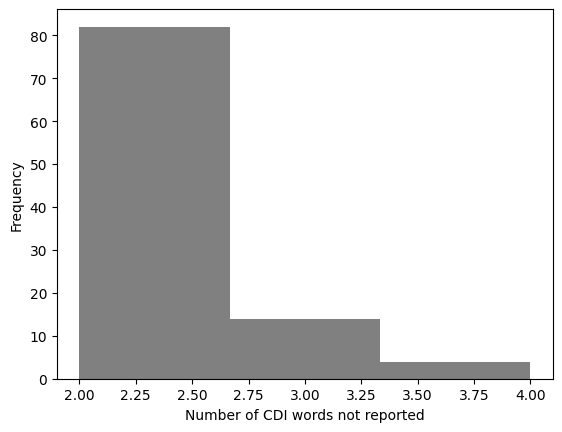

In [20]:
import matplotlib.pyplot as plt

plot_topics = plt.hist(number_of_topics_all, bins=3,facecolor='grey')

plt.xlabel('Number of CDI words not reported')
plt.ylabel('Frequency')

#plt.savefig('missing_CDI_words.png', bbox_inches='tight')



### Word frequency list

In [21]:
top_words_all = [] #  all the words that made it to the list of top words
for sublist in top_words_list:
    for val in sublist:
        top_words_all.append(val)
#top_words_all

In [22]:
import collections
top_words_freq = collections.Counter(top_words_all) # here I count how many times each unique word has appeared in the top words list
#top_words_freq

In [23]:
top_words_freq_df = pd.DataFrame.from_dict(top_words_freq, orient='index', columns=['frequency']).reset_index()
top_words_freq_df.columns.values[0] = "word"
top_words_freq_df.to_csv('top_words_freq_df.csv')

In [24]:
#,top_words_freq # 128 unique top words and their freqency as top words
top_words_freq_df.shape

(128, 2)

In [25]:
top_words_set = set(top_words_all)
top_words_set = list(top_words_set)
#top_words_set

In [26]:
type(top_words_freq)
top_words_freq.most_common(400)

[('yummy', 100),
 ('spoon', 100),
 ('fork', 100),
 ('eat', 100),
 ('lie', 97),
 ('bed', 82),
 ('yogurt', 82),
 ('stand', 80),
 ('bedroom', 77),
 ('nappy', 71),
 ('trousers', 68),
 ('fruit', 63),
 ('place', 61),
 ('eating', 60),
 ('weetabix', 52),
 ('sleep', 50),
 ('beans', 47),
 ('yoghurt', 44),
 ('arm', 40),
 ('bowl', 35),
 ('toast', 33),
 ('lights', 32),
 ('rice', 32),
 ('breakfast', 31),
 ('towel', 24),
 ('come', 24),
 ('table', 23),
 ('change', 22),
 ('bottom', 22),
 ('anything', 22),
 ('toothbrush', 20),
 ('tasty', 20),
 ('triangle', 18),
 ('animal', 18),
 ('lorry', 17),
 ('fit', 17),
 ('yum', 17),
 ('build', 16),
 ('crash', 16),
 ('shape', 15),
 ('goodnight', 14),
 ('washed', 14),
 ('circle', 13),
 ('porridge', 13),
 ('zebra', 13),
 ('engine', 13),
 ('pyjamas', 12),
 ('whee', 12),
 ('teeth', 11),
 ('bib', 11),
 ('shampoo', 10),
 ('shoulders', 10),
 ('even', 9),
 ('vroom', 9),
 ('reading', 8),
 ('train', 8),
 ('arms', 8),
 ('light', 8),
 ('dark', 7),
 ('legs', 7),
 ('soap', 7),
 (

###  Assign topics to models


#### Using the three most frequent top topic words


In [27]:

MEALTIME= ['spoon','fork','yummy']

BEDTIME= ['bed','sleep','bedroom']

BATHTIME= ['arm','washed','towel']

PLAYTIME= ['triangle','animal','lorry']

NAPPYTIME= ['change','nappy','bottom']




Topic_model_3_words = []


for model in range(1,101):    
    model_i = Top2Vec.load(f"model_{model :03}" )

    number_of_topics = []
    
    topic_sizes, topic_nums = model_i.get_topic_sizes()
    number_of_topics.append((len(topic_nums)))
        
    s = [str(integer) for integer in number_of_topics]
    a_string = "".join(s)
    number_of_topics = int(a_string)
    
    topic_words, word_scores, topic_nums = model_i.get_topics(number_of_topics)    
    
    Topic_model =[]
    
    for topic in topic_words:
        
        Topic_models_i =[]
    
        if MEALTIME[0]  in topic or MEALTIME[1] in topic or MEALTIME[2] in topic:
            Topic_models_i.append('MEAL')
        if BEDTIME[0] in topic or BEDTIME[1] in topic or BEDTIME[2] in topic:
            Topic_models_i.append('BED')
        if BATHTIME[0]  in topic or BATHTIME[1] in topic  or BATHTIME[2] in topic:
            Topic_models_i.append('BATH')
        if PLAYTIME[0]  in topic or PLAYTIME[1] in topic or PLAYTIME[2] in topic:
            Topic_models_i.append('PLAY')
        if NAPPYTIME[0] in topic or NAPPYTIME[1] in topic or NAPPYTIME[2] in topic:
            Topic_models_i.append('NAPPY')
                
        Topic_model.append((Topic_models_i))
        
    Topic_model_3_words.append(Topic_model)

### Count how many times the documents were correctly classified

#### Three top topic words to identify the topic

In [28]:

filenames_and_topics_dict_3 = {}

for idx,doc in enumerate(filenames_and_topics):
    filenames_and_topics_dict_3[doc[2]]= doc[1]




doc_topics_scores = {}

for idx,doc in enumerate(filenames_and_topics):
    doc_topics_scores[doc[2]]=0


for model in range(1,101):    

    #print(model)
    model_i = Top2Vec.load(f"model_{model :03}" )
    
    Topic_model_i = Topic_model_3_words[((model-1))]
    
    number_of_topics = []
    topic_sizes, topic_nums = model_i.get_topic_sizes()
    
    number_of_topics.append((len(topic_nums)))
            
    s = [str(integer) for integer in number_of_topics]
    a_string = "".join(s)
    num_topics = int(a_string)
    
    
    document_ids_list =[]
    for topic_i in range(0,num_topics):
        
        #topic_words, word_scores, topic_nums = model_i.get_topics(topic_nums)  
        documents, document_scores, document_ids = model_i.search_documents_by_topic(topic_num=topic_i, num_docs=topic_sizes[topic_i])
        
        document_ids_list.append(document_ids)
        if len(Topic_model_i[topic_i]) == 1:
            topic_cluster_score = 1
        
        if len(Topic_model_i[topic_i]) == 2:
            topic_cluster_score = 0.5
            
        if len(Topic_model_i[topic_i]) >= 3 :
            topic_cluster_score = 0.25
    
        for doc in document_ids:
            if filenames_and_topics_dict_3[doc] in Topic_model_i[topic_i]:
                doc_topics_scores[doc] = doc_topics_scores[doc] + topic_cluster_score

In [29]:
topics_models_dict = {}
topics_models_dict[str(Topic_model_3_words[0])] = 1

str(Topic_model_3_words[0]) in topics_models_dict
print(str(Topic_model_3_words[0]))
print(str(Topic_model_3_words[2]))

[['BED', 'BATH', 'PLAY', 'NAPPY'], ['MEAL']]
[['BED', 'BATH', 'PLAY', 'NAPPY'], ['MEAL']]


In [30]:
topics_models_dict = {}

for i,model in enumerate(Topic_model_3_words):
    if str(model) in topics_models_dict:
        topics_models_dict[str(model)] = (topics_models_dict[str(model)] +1)
    else:
        topics_models_dict[str(model)] = 1



In [31]:
### Detected topics ###
topics_models_dict

{"[['BED', 'BATH', 'PLAY', 'NAPPY'], ['MEAL']]": 81,
 "[['BED', 'BATH', 'NAPPY'], ['MEAL'], ['PLAY']]": 9,
 "[['BED', 'BATH', 'NAPPY'], ['MEAL'], ['PLAY'], ['BED', 'PLAY']]": 3,
 "[['BED', 'BATH', 'NAPPY'], ['MEAL'], ['BED', 'PLAY'], ['PLAY']]": 1,
 "[['BED', 'BATH', 'NAPPY'], ['PLAY'], ['MEAL']]": 4,
 "[['BED', 'BATH', 'NAPPY'], ['BED', 'PLAY'], ['MEAL']]": 1,
 "[['BED', 'BATH', 'NAPPY'], ['MEAL']]": 1}

38.89235412474849
25.0
30.30651931175366
100
0
[0, 0.25, 1.5, 1.75, 2, 4, 4.5, 6.5, 7.5, 8, 8.25, 9.75, 13.25, 13.75, 14.0, 15.5, 15.75, 16.0, 19.25, 19.5, 19.75, 20.0, 20.25, 20.5, 20.75, 21.0, 21.25, 21.5, 21.75, 22.0, 22.25, 22.5, 23.0, 23.25, 23.5, 23.75, 24.0, 24.25, 24.5, 24.75, 25.0, 25.25, 25.5, 25.75, 26.0, 26.25, 26.75, 28.5, 28.75, 29.75, 30.75, 31.75, 32.75, 33.25, 34.25, 34.75, 35.25, 35.75, 36.25, 36.5, 36.75, 37.0, 37.25, 37.5, 37.75, 79, 87, 97, 99, 100]
Counter({25.0: 143, 100: 89, 37.75: 53, 0: 22, 24.75: 13, 26.0: 12, 23.5: 10, 25.75: 8, 20.5: 8, 24.5: 7, 25.5: 7, 26.25: 7, 23.0: 6, 35.75: 6, 32.75: 5, 23.25: 5, 20.25: 5, 23.75: 4, 21.25: 4, 25.25: 4, 24.0: 4, 36.75: 4, 37.25: 4, 22.5: 3, 21.5: 3, 36.25: 3, 21.75: 3, 24.25: 3, 22.25: 2, 34.75: 2, 2: 2, 22.0: 2, 37.5: 2, 19.75: 2, 9.75: 2, 33.25: 2, 20.75: 2, 0.25: 2, 20.0: 1, 4: 1, 1.75: 1, 30.75: 1, 4.5: 1, 19.25: 1, 14.0: 1, 8.25: 1, 28.5: 1, 26.75: 1, 8: 1, 1.5: 1, 15.75: 1, 13.75: 1, 13.25: 1, 16.0: 1, 37.0: 1, 3

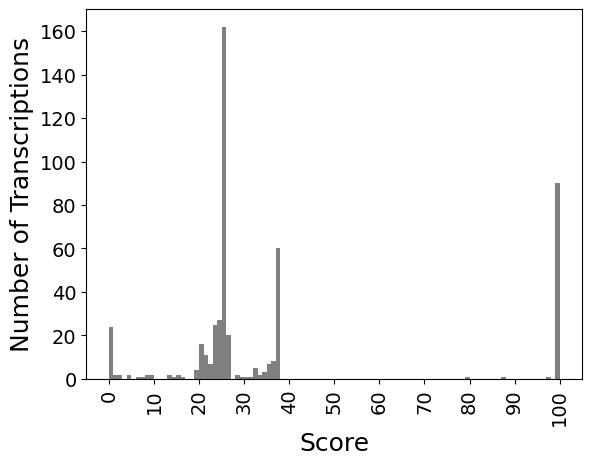

In [32]:
list_doc_topics_scores = []
for key in doc_topics_scores:
    list_doc_topics_scores.append(doc_topics_scores[key])

import statistics

print(statistics.mean(list_doc_topics_scores))
print(statistics.median(list_doc_topics_scores))
print(statistics.stdev(list_doc_topics_scores))
print(max(list_doc_topics_scores))
print(min(list_doc_topics_scores))

print(sorted(collections.Counter(list_doc_topics_scores)))
print(collections.Counter(list_doc_topics_scores))

import matplotlib.pyplot as plt


plot_topics = plt.hist(list_doc_topics_scores, bins=100,facecolor='grey')
plt.xlabel('Score',fontsize=18)
plt.ylabel('Number of Transcriptions',fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.xticks(np.arange(min(list_doc_topics_scores), max(list_doc_topics_scores)+1, 10))
plt.yticks(fontsize=14)

plt.savefig('Figure_1_Panel_A_Correct Topic Score', bbox_inches='tight')
#doc_topics_scores

In [ ]:
topic_high_score_trans =[]
for i,(key,value) in enumerate(doc_topics_scores.items()):
    if value == 100:
        topic_high_score_trans.append(key)

In [74]:
#topic_high_score_trans

In [34]:
topic_low_score_trans =[]
for i,(key,value) in enumerate(doc_topics_scores.items()):
    if value == 0:
        topic_low_score_trans.append(key)

In [76]:
#topic_low_score_trans

In [35]:
score_by_topic_3 =  {'MEAL': 0,
                   'BED': 0,
                   'BATH':0,
                   'NAPPY':0,
                   'PLAY':0
                  }

BATH_filenames = []
BED_filenames = []
PLAY_filenames = []
MEAL_filenames = []
NAPPY_filenames = []

for i in filenames_and_topics:
    #print(i[1])
    if i[1] == 'BATH':
        BATH_filenames.append(i[2])
    if i[1] == 'BED':
        BED_filenames.append(i[2])
    if i[1] == 'PLAY':
        PLAY_filenames.append(i[2])
    if i[1] == 'MEAL':
        MEAL_filenames.append(i[2])
    if i[1] == 'NAPPY':
        NAPPY_filenames.append(i[2])

        
     

for i,(key,value) in enumerate(doc_topics_scores.items()):
    #print(i,key,value)
    
    if key in BATH_filenames:
        score_by_topic_3['BATH'] = score_by_topic_3['BATH']+  value
    if key in BED_filenames:
        score_by_topic_3['BED']=  score_by_topic_3['BED']+  value
    if key in PLAY_filenames:
        score_by_topic_3['PLAY']=  score_by_topic_3['PLAY']+  value
    if key in MEAL_filenames:
        score_by_topic_3['MEAL']= score_by_topic_3['MEAL']+  value
    if key in NAPPY_filenames:
        score_by_topic_3['NAPPY']= score_by_topic_3['NAPPY']+  value
  

In [36]:
print(score_by_topic_3)

score_by_topic_3['BATH'] = score_by_topic_3['BATH'] / len(BATH_filenames)
score_by_topic_3['BED'] = score_by_topic_3['BED'] / len(BED_filenames)
score_by_topic_3['PLAY'] = score_by_topic_3['PLAY'] / len(PLAY_filenames)
score_by_topic_3['MEAL'] = score_by_topic_3['MEAL'] / len(MEAL_filenames)
score_by_topic_3['NAPPY'] = score_by_topic_3['NAPPY'] / len(NAPPY_filenames)


print(score_by_topic_3)

{'MEAL': 9262, 'BED': 2061.0, 'BATH': 2212.0, 'NAPPY': 1942.25, 'PLAY': 3852.25}
{'MEAL': 97.49473684210527, 'BED': 23.96511627906977, 'BATH': 24.043478260869566, 'NAPPY': 21.11141304347826, 'PLAY': 29.18371212121212}


[97.49473684210527, 23.96511627906977, 24.043478260869566, 21.11141304347826, 29.18371212121212]
['MEAL', 'BED', 'BATH', 'NAPPY', 'PLAY']


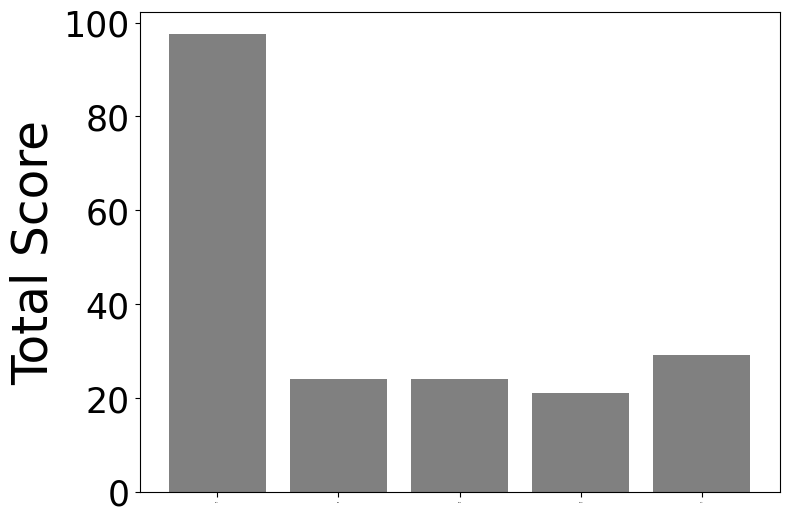

In [37]:

import matplotlib.pyplot as plt

score_by_topic_3_labels= []
score_by_topic_3_scores= []

for key in score_by_topic_3:
    score_by_topic_3_scores.append(score_by_topic_3[key])
    score_by_topic_3_labels.append(key)

print(score_by_topic_3_scores)
    
print(score_by_topic_3_labels)

plot_topics =plt.figure()
ax = plot_topics.add_axes([0,0,1,1])

ax.bar(score_by_topic_3_labels,score_by_topic_3_scores, color="grey")
plt.xlabel('',fontsize=0)

plt.ylabel('Total Score',fontsize=35)
plt.xticks(fontsize=0)
#plt.xticks(np.arange(min(score_by_topic_3), max(score_by_topic_3)+1, 5))
plt.yticks(fontsize=25)


plt.savefig('Figure_1_Panel_B_Total by topic_1', bbox_inches='tight')



### Scores when correctly classified as the only topic

#### Three top topic words to identify the topic

In [38]:
#os.chdir(r"D:/Documents/Learning/SavedModels")
doc_topics_scores_ONLY_TOPIC_3 = {}

for idx,doc in enumerate(filenames_and_topics):
    doc_topics_scores_ONLY_TOPIC_3[doc[2]]=0


for model in range(1,101):    

    #print(model)
    model_i = Top2Vec.load(f"model_{model :03}" )
    
    Topic_model_i = Topic_model_3_words[((model-1))] ##
    
    number_of_topics = []
    topic_sizes, topic_nums = model_i.get_topic_sizes()
    
    number_of_topics.append((len(topic_nums)))
            
    s = [str(integer) for integer in number_of_topics]
    a_string = "".join(s)
    num_topics = int(a_string)
    
    
    document_ids_list =[]
    for topic_i in range(0,num_topics):
        
        #topic_words, word_scores, topic_nums = model_i.get_topics(topic_nums)  
        documents, document_scores, document_ids = model_i.search_documents_by_topic(topic_num=topic_i, num_docs=topic_sizes[topic_i])
        
        document_ids_list.append(document_ids)
        if len(Topic_model_i[topic_i]) == 1:
            topic_cluster_score = 1

        if len(Topic_model_i[topic_i]) >= 2 :
            topic_cluster_score = 0
    
        for doc in document_ids:
            if filenames_and_topics_dict_3[doc] in Topic_model_i[topic_i]:
                doc_topics_scores_ONLY_TOPIC_3[doc] = doc_topics_scores_ONLY_TOPIC_3[doc] + topic_cluster_score
                
#############


score_by_topic_ONLY_TOPIC_3 =  {'MEAL': 0,
                   'BED': 0,
                   'BATH':0,
                   'NAPPY':0,
                   'PLAY':0
                  }

BATH_filenames = []
BED_filenames = []
PLAY_filenames = []
MEAL_filenames = []
NAPPY_filenames = []

for i in filenames_and_topics:
    #print(i[1])
    if i[1] == 'BATH':
        BATH_filenames.append(i[2])
    if i[1] == 'BED':
        BED_filenames.append(i[2])
    if i[1] == 'PLAY':
        PLAY_filenames.append(i[2])
    if i[1] == 'MEAL':
        MEAL_filenames.append(i[2])
    if i[1] == 'NAPPY':
        NAPPY_filenames.append(i[2])

        
        
for i,(key,value) in enumerate(doc_topics_scores_ONLY_TOPIC_3.items()):
    #print(i,key,value)
    
    if key in BATH_filenames:
        score_by_topic_ONLY_TOPIC_3['BATH'] = score_by_topic_ONLY_TOPIC_3['BATH']+  value
    if key in BED_filenames:
        score_by_topic_ONLY_TOPIC_3['BED']=  score_by_topic_ONLY_TOPIC_3['BED']+  value
    if key in PLAY_filenames:
        score_by_topic_ONLY_TOPIC_3['PLAY']=  score_by_topic_ONLY_TOPIC_3['PLAY']+  value
    if key in MEAL_filenames:
        score_by_topic_ONLY_TOPIC_3['MEAL']= score_by_topic_ONLY_TOPIC_3['MEAL']+  value
    if key in NAPPY_filenames:
        score_by_topic_ONLY_TOPIC_3['NAPPY']= score_by_topic_ONLY_TOPIC_3['NAPPY']+  value
  

In [39]:
print(score_by_topic_ONLY_TOPIC_3)

score_by_topic_ONLY_TOPIC_3['BATH'] = score_by_topic_ONLY_TOPIC_3['BATH'] / len(BATH_filenames)
score_by_topic_ONLY_TOPIC_3['BED'] = score_by_topic_ONLY_TOPIC_3['BED'] / len(BED_filenames)
score_by_topic_ONLY_TOPIC_3['PLAY'] = score_by_topic_ONLY_TOPIC_3['PLAY'] / len(PLAY_filenames)
score_by_topic_ONLY_TOPIC_3['MEAL'] = score_by_topic_ONLY_TOPIC_3['MEAL'] / len(MEAL_filenames)
score_by_topic_ONLY_TOPIC_3['NAPPY'] = score_by_topic_ONLY_TOPIC_3['NAPPY'] / len(NAPPY_filenames)

print(score_by_topic_ONLY_TOPIC_3)

{'MEAL': 9262, 'BED': 0, 'BATH': 0, 'NAPPY': 0, 'PLAY': 1560}
{'MEAL': 97.49473684210527, 'BED': 0.0, 'BATH': 0.0, 'NAPPY': 0.0, 'PLAY': 11.818181818181818}


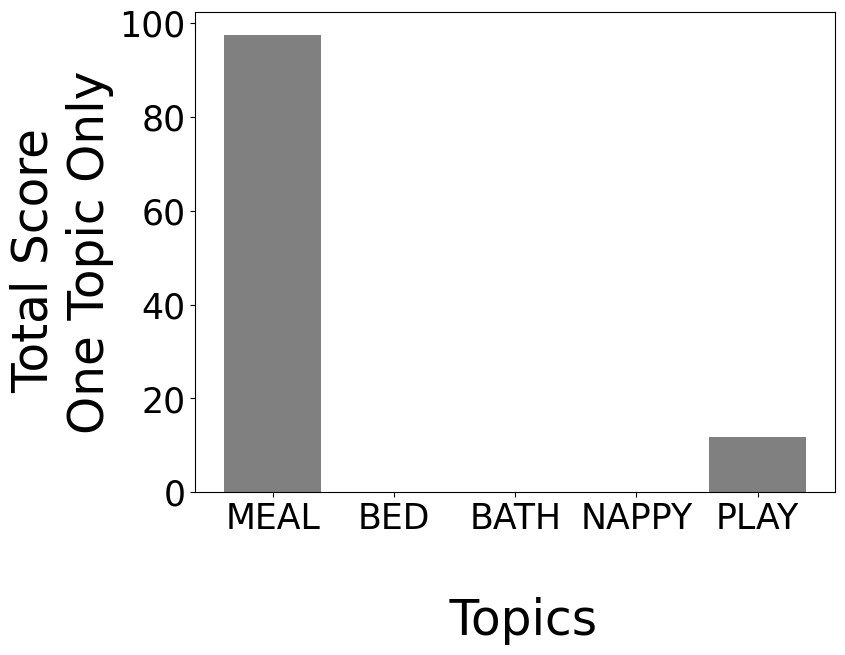

In [40]:

import matplotlib.pyplot as plt

score_by_topic_ONLY_TOPIC_3_labels= []
score_by_topic_ONLY_TOPIC_3_scores= []

for key in score_by_topic_ONLY_TOPIC_3:
    score_by_topic_ONLY_TOPIC_3_scores.append(score_by_topic_ONLY_TOPIC_3[key])
    score_by_topic_ONLY_TOPIC_3_labels.append(key)



plot_topics =plt.figure()
ax = plot_topics.add_axes([0,0,1,1])

ax.bar(score_by_topic_ONLY_TOPIC_3_labels,score_by_topic_ONLY_TOPIC_3_scores, color="grey")

plt.ylabel('Total Score \nOne Topic Only',fontsize=35)
plt.xlabel(' \n Topics',fontsize=35)
#plt.xticks(np.arange(min(score_by_topic_3), max(score_by_topic_3)+1, 5))
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)


plt.savefig('Figure_1_Panel_C_Total by topic_2', bbox_inches='tight')





## Topic co-occurrence

### Three top topic word

In [41]:
topic_cooccurrence_matrix_v = ([0] * 5)
topic_cooccurrence_matrix= []

for i in range(0,5):
    
    topic_cooccurrence_matrix.append(topic_cooccurrence_matrix_v)
    
topic_cooccurrence_labels = ['MEAL','BED','BATH','NAPPY','PLAY']
topic_cooccurrence_matrix

topic_cooccurrence_matrix = np.array(topic_cooccurrence_matrix)


for topics_model in Topic_model_3_words:
    for topic_model_i in topics_model:
        if len(topic_model_i)==2:
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[1])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[1])])+1
        if len(topic_model_i)==3:
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[1])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[1])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[2])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[2])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[2])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[2])])+1
        if len(topic_model_i)==4:
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[1])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[1])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[2])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[2])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[2])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[2])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[3])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[3])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[3])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[3])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[2])] [topic_cooccurrence_labels.index(topic_model_i[3])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[2])] [topic_cooccurrence_labels.index(topic_model_i[3])])+1

        if len(topic_model_i)==5:
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[1])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[1])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[2])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[2])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[2])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[2])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[3])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[3])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[3])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[3])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[2])] [topic_cooccurrence_labels.index(topic_model_i[3])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[2])] [topic_cooccurrence_labels.index(topic_model_i[3])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[4])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[0])] [topic_cooccurrence_labels.index(topic_model_i[4])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[4])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[1])] [topic_cooccurrence_labels.index(topic_model_i[4])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[2])] [topic_cooccurrence_labels.index(topic_model_i[4])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[2])] [topic_cooccurrence_labels.index(topic_model_i[4])])+1
            topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[3])] [topic_cooccurrence_labels.index(topic_model_i[4])] = (topic_cooccurrence_matrix[topic_cooccurrence_labels.index(topic_model_i[3])] [topic_cooccurrence_labels.index(topic_model_i[4])])+1


In [42]:
topic_cooccurrence_labels,topic_cooccurrence_matrix

(['MEAL', 'BED', 'BATH', 'NAPPY', 'PLAY'],
 array([[  0,   0,   0,   0,   0],
        [  0,   0, 100, 100,  86],
        [  0,   0,   0, 100,  81],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,  81,   0]]))

## VOCABULARIES

### 1. Load vocabuaries and format

In [43]:
os.chdir("../Vocabularies and other data")

In [44]:
#Vocabularies =   pd.read_csv('df_participants.csv', encoding='latin')
import pyreadr
Vocabularies =  pyreadr.read_r('df_participants.rds') # also works for RData
Vocabularies
Vocabularies = Vocabularies[None]

In [45]:
type(Vocabularies)

pandas.core.frame.DataFrame

In [46]:
Vocabularies.shape

(1695, 689)

In [47]:
Vocabularies

,part_ID,baa baa,baby,ball,banana,bath,bicycle / bike,bin,breakfast,bubble,...,an,babysitter,rocking chair,Prod,Compr,Prod_cum,Compr_cum,age,day_of_data_entry,data_entry_number
0,P_0130,2,2,2,2,1,1,2,1,,...,,,,68,207,68,207,19.1346659652814,0.0,1
1,P_0130,,,,,,,,,2,...,,,,23,172,91,379,20.2853761178327,35.0,2
2,P_0130,,,,,,2,,,,...,,,,11,34,102,413,21.3374539715939,67.0,3
3,P_0130,,,,,,,,,,...,,,,2,3,104,416,21.3703314045239,68.0,4
4,P_0130,,,,,,,,,,...,,,,2,3,106,419,21.436086270384,70.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690,P_0524,,,,2,2,,,,,...,,,,10,10,167,440,24.5923198316675,115.0,10
1691,P_0524,,,,,,,2,,,...,,,,27,27,194,467,24.8882167280379,124.0,11
1692,P_0524,,,,,,,,,,...,,,,27,32,221,499,25.2827459231983,136.0,12
1693,P_0524,,,,,,,,,,...,,,,41,41,262,540,26.2033140452393,164.0,13


In [48]:
index_new_df =[]

for i in range(0,len(set(Vocabularies['part_ID']))):
    
    id_child = list(set(Vocabularies['part_ID']))[i]
    
    vocab_child = Vocabularies[Vocabularies['part_ID']==id_child]
    vocab_child = vocab_child[vocab_child['data_entry_number']==len(vocab_child)]
    
    s = [str(integer) for integer in vocab_child.index]
    a_string = "".join(s)
    vocab_child_index = int(a_string)
    
    index_new_df.append(vocab_child_index)
    
Vocabularies_last_entry = Vocabularies.iloc[index_new_df]

Vocabularies_last_entry

,part_ID,baa baa,baby,ball,banana,bath,bicycle / bike,bin,breakfast,bubble,...,an,babysitter,rocking chair,Prod,Compr,Prod_cum,Compr_cum,age,day_of_data_entry,data_entry_number
289,P_0203,,,,,,,,,,...,,,,24,60,182,440,18.773014203051,167.0,8
582,P_0266,,,,,,,,,,...,,,,1,2,288,583,27.1896370331405,191.0,80
736,P_0298,,,,,,,,,,...,,,,5,5,324,660,28.3732246186218,151.0,20
630,P_0277,,,,,,,2,,,...,,,,29,37,322,512,20.4497632824829,169.0,19
130,P_0180,,,,,,,,2,,...,,,,54,69,178,514,21.0415570752236,162.0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,P_0286,,,,,,,,,,...,,,,22,39,233,406,23.5073645449763,105.0,18
1286,P_0437,,,,,,1,,,2,...,,,,21,56,68,263,20.0223566543924,144.0,9
1556,P_0498,,,,,,,,,,...,,,,45,56,226,345,21.3374539715939,172.0,33
1475,P_0463,,,,,,,,,,...,,,,1,2,382,832,19.7264597580221,175.0,68


In [49]:
vocabularies_dict = {}

for i in range(0,len(set(Vocabularies['part_ID']))):
#for i in range(0,10):

    #print(i)
    id_child = list(set(Vocabularies['part_ID']))[i]
    
    vocab_child = Vocabularies[Vocabularies['part_ID']==id_child]
    index_x =[vocab_child.columns.get_loc("baa baa"), vocab_child.columns.get_loc("rocking chair")]
    vocab_child_only_words = vocab_child.iloc[:,index_x[0]:index_x[1]+1]
  
    words_produced_child = []

    for x in range(0,len(vocab_child_only_words)):
        for y in range(0,vocab_child_only_words.shape[1]):
            myvar = (vocab_child_only_words.iloc[x,y] == '2')
            myvar = str(myvar)
            myvar = re.findall("True|False", myvar)
            #print(vocab_child_only_words)

            if myvar == ['True'] :
                words_produced_child.append(list(vocab_child_only_words.columns)[y])
       # print(words_produced_child)
    vocabularies_dict[Vocabularies_last_entry.iloc[i,Vocabularies_last_entry.columns.get_loc("part_ID")]] = words_produced_child



In [50]:
import os
os.getcwd()
words_CDI =   pd.read_csv('words_CDI_fixed_df.csv', encoding='latin')
#import pyreadr
#words_CDI =  pyreadr.read_r('words_CDI.rds') # also works for RData
#words_CDI
#words_CDI = words_CDI[None]

In [51]:
words_CDI.shape
words_CDI

,Unnamed: 0,words_in_CDI,words_fixed,word_per_item,homonyms,ngram,words_fixed_stem,in_envir,words_in_envir,freq_total,semantic_category,synt_class
0,1,all,all,1,0,1,all,unigram,all,2752,quantifiers,other
1,2,all gone,all_gone,1,0,2,all_gone,bigram,all_gone,209,descriptive_words,other
2,3,animal,animal,1,0,1,anim,unigram,anim,186,animals,Noun
3,4,another,another,1,0,1,anoth,unigram,anoth,376,quantifiers,other
4,5,apple,apple,1,0,1,appl,unigram,appl,213,food_drink,Noun
...,...,...,...,...,...,...,...,...,...,...,...,...
714,2301,tv / television / telly,television,3,0,1,televis,unigram,televis,3,furniture_rooms,Noun
715,2302,tv / television / telly,telly,3,0,1,telli,unigram,telli,28,furniture_rooms,Noun
716,5141,church / mosque / synagogue /temple,mosque,4,0,1,mosqu,NaN,NaN,0,places,Noun
717,5142,church / mosque / synagogue /temple,synagogue,4,0,1,synagogu,NaN,NaN,0,places,Noun


In [52]:
#vocabularies_dict['P_0130']

In [53]:
# some items in the checklist are composed of two or more words

words_deleted = []

for i,(key,value) in enumerate(vocabularies_dict.items()):
    words_deleted_i = []
    for x in range(0,len(value)):
        if words_CDI['words_in_CDI'].eq(value[x]).any():
            word_repl = words_CDI['words_fixed'][list(words_CDI['words_in_CDI']).index(value[x])]
            vocabularies_dict[key][x] = word_repl
        else : # delete the words id it that's match with or is not in the list 'words_CDI'
            words_deleted_i.append(value[x])
    for z in words_deleted_i:
        vocabularies_dict[key].remove(z)
   
    words_deleted.append(words_deleted_i)

In [54]:
flat_list = [item for sublist in words_deleted for item in sublist]

In [55]:
set(flat_list)

{'babysitter’s name',
 'child’s own name',
 'don’t',
 'gonna get you!',
 'pet’s name',
 'so big!',
 'this little piggy'}

In [56]:
#vocabularies_dict['P_0130']

### 2. Retrieve words produced by child_1 

In [57]:
# Fix speakers

for i in range(0, (len(transcripts_all))):
    
    if transcripts_all['Speaker'][i] == 'Child':
        transcripts_all['Speaker'][i] = 'Child_1'
    
    if transcripts_all['Speaker'][i] == 'female':
        transcripts_all['Speaker'][i] = 'Female_1'        
    
    if transcripts_all['Speaker'][i] == 'Female':
        transcripts_all['Speaker'][i] = 'Female_1'
    
    if transcripts_all['Speaker'][i] == 'Make':
        transcripts_all['Speaker'][i] = 'Male_1'
    
    if transcripts_all['Speaker'][i] == 'Male':
        transcripts_all['Speaker'][i] = 'Male_1'
    
    if transcripts_all['Speaker'][i] == 'Female _2':
        transcripts_all['Speaker'][i] = 'Female_2'        
    
    if transcripts_all['Speaker'][i] == 'Male\r\n':
        transcripts_all['Speaker'][i] = 'Male_1'
    
    if transcripts_all['Speaker'][i] == 'Child_':
        transcripts_all['Speaker'][i] = 'Child_1'

    if transcripts_all['Speaker'][i] == 'Child_1\r\n':
        transcripts_all['Speaker'][i] = 'Child_1'
    
    if transcripts_all['Speaker'][i] == 'Child_2\r\n':
        transcripts_all['Speaker'][i] = 'Child_2'        
    
    if transcripts_all['Speaker'][i] == 'Female\r\n':
        transcripts_all['Speaker'][i] = 'Female_1'
    
    if transcripts_all['Speaker'][i] == 'Man':
        transcripts_all['Speaker'][i] = 'Male_1'
    
    if transcripts_all['Speaker'][i] == 'Mother:':
        transcripts_all['Speaker'][i] = 'Female_1'
    
    if transcripts_all['Speaker'][i] == 'Father:':
        transcripts_all['Speaker'][i] = 'Male_1'        
    
    if transcripts_all['Speaker'][i] == 'Female 1:':
        transcripts_all['Speaker'][i] = 'Female_1'
    
    if transcripts_all['Speaker'][i] == 'Female':
        transcripts_all['Speaker'][i] = 'Female_1'

    if transcripts_all['Speaker'][i] == 'Baby:':
        transcripts_all['Speaker'][i] = 'Child_1'        
    
    if transcripts_all['Speaker'][i] == 'Child 1:':
        transcripts_all['Speaker'][i] = 'Child_1'
    
    if transcripts_all['Speaker'][i] == 'Child 2:':
        transcripts_all['Speaker'][i] = 'Child_2'

    if transcripts_all['Speaker'][i] == 'Child:':
        transcripts_all['Speaker'][i] = 'Child_1'
    
    if transcripts_all['Speaker'][i] == 'child_2':
        transcripts_all['Speaker'][i] = 'Child_2'    
        
    if transcripts_all['Speaker'][i] == 'Male:':
        transcripts_all['Speaker'][i] = 'Male_1'
    
    if transcripts_all['Speaker'][i] == 'Male 1:':
        transcripts_all['Speaker'][i] = 'Male_1'
    
    if transcripts_all['Speaker'][i] == 'Female:':
        transcripts_all['Speaker'][i] = 'Female_1'        
    
    if transcripts_all['Speaker'][i] == 'Chlid:':
        transcripts_all['Speaker'][i] = 'Child_1'
    
    if transcripts_all['Speaker'][i] == 'child_2':
        transcripts_all['Speaker'][i] = 'Child_2'

    if transcripts_all['Speaker'][i] == 'Chiild':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'Chlild_1':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'Male & Child':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'child':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'child_1':
        transcripts_all['Speaker'][i] = 'Child_1'

    if transcripts_all['Speaker'][i] == 'Parent:':
        transcripts_all['Speaker'][i] = 'Female_1'
        
    if transcripts_all['Speaker'][i] == 'Adult:':
        transcripts_all['Speaker'][i] = 'Female_1'
        
    if transcripts_all['Speaker'][i] == 'Baby':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'Chid':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'CHILD':
        transcripts_all['Speaker'][i] = 'Child_1'

    if transcripts_all['Speaker'][i] == 'Child 1':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'Child 2':
        transcripts_all['Speaker'][i] = 'Child_2'
        
    if transcripts_all['Speaker'][i] == 'Child and Female':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'Child.':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'Child2':
        transcripts_all['Speaker'][i] = 'Child_2'
  
    if transcripts_all['Speaker'][i] == 'Chile':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'Daddy':
        transcripts_all['Speaker'][i] = 'Male_1'
        
    if transcripts_all['Speaker'][i] == 'Child and Female':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'FEmale':
        transcripts_all['Speaker'][i] = 'Female_1'

    if transcripts_all['Speaker'][i] == 'Female / Male':
        transcripts_all['Speaker'][i] = 'Female_1'
        
    if transcripts_all['Speaker'][i] == 'Female 1':
        transcripts_all['Speaker'][i] = 'Female_1'
        
    if transcripts_all['Speaker'][i] == 'Female 1 and Female 2':
        transcripts_all['Speaker'][i] = 'Female_1'
        
    if transcripts_all['Speaker'][i] == 'Female 2':
        transcripts_all['Speaker'][i] = 'Female_2'
        
    if transcripts_all['Speaker'][i] == 'Female.':
        transcripts_all['Speaker'][i] = 'Female_1'

    if transcripts_all['Speaker'][i] == 'Female/Male':
        transcripts_all['Speaker'][i] = 'Female_1'
        
    if transcripts_all['Speaker'][i] == 'Female2':
        transcripts_all['Speaker'][i] = 'Female_2'
        
    if transcripts_all['Speaker'][i] == 'Femate':
        transcripts_all['Speaker'][i] = 'Female_1'
        
    if transcripts_all['Speaker'][i] == 'MALE':
        transcripts_all['Speaker'][i] = 'Male_1'
        
    if transcripts_all['Speaker'][i] == 'Male and Female':
        transcripts_all['Speaker'][i] = 'Female_1'
  
    if transcripts_all['Speaker'][i] == 'Male/Child':
        transcripts_all['Speaker'][i] = 'Child_1'
        
    if transcripts_all['Speaker'][i] == 'Male/Female':
        transcripts_all['Speaker'][i] = 'Female_1'
        
    if transcripts_all['Speaker'][i] == 'Male2':
        transcripts_all['Speaker'][i] = 'Male_2'
        
    if transcripts_all['Speaker'][i] == 'Males':
        transcripts_all['Speaker'][i] = 'Male_2'
        
    if transcripts_all['Speaker'][i] == 'Child_1\n':
        transcripts_all['Speaker'][i] = 'Child_1'

    if transcripts_all['Speaker'][i] == 'Child_2\n':
        transcripts_all['Speaker'][i] = 'Child_2'
        
    if transcripts_all['Speaker'][i] == 'Female\n':
        transcripts_all['Speaker'][i] = 'Female_1'
        
    if transcripts_all['Speaker'][i] == 'Male\n':
        transcripts_all['Speaker'][i] = 'Male_1'
        
        
    if transcripts_all['Speaker'][i] == 'Child _1':
        transcripts_all['Speaker'][i] = 'Child_1'
    
    if transcripts_all['Speaker'][i] == 'Child _2':
        transcripts_all['Speaker'][i] = 'Child_2'
    
    if transcripts_all['Speaker'][i] == 'Child _3':
        transcripts_all['Speaker'][i] = 'Child_3'
    
    if transcripts_all['Speaker'][i] == 'Chlid':
        transcripts_all['Speaker'][i] = 'Child_1'
   
    if transcripts_all['Speaker'][i] == 'Famale_1':
        transcripts_all['Speaker'][i] = 'Female_1'
    
    if transcripts_all['Speaker'][i] == 'Famale_2':
        transcripts_all['Speaker'][i] = 'Female_1'
        



In [58]:
set(transcripts_all['Speaker'])

{'()',
 'Break in Conversation',
 'Break_In_Conversation',
 'Break_in_Conversation',
 'Break_in_Convesrsation',
 'Break_in_conversation',
 'Child_1',
 'Child_2',
 'Child_3',
 'Comment',
 'Dog',
 'Female_1',
 'Female_2',
 'Long Pause',
 'Male_1',
 'Male_2',
 '[]',
 '___',
 'comment',
 nan}

In [59]:
collections.Counter(transcripts_all['Speaker'])

Counter({'Female_1': 37310,
         'Child_1': 36579,
         nan: 9350,
         'Male_1': 8340,
         '[]': 244,
         '()': 246,
         '___': 242,
         'Child_2': 2535,
         'Break_in_conversation': 250,
         'Child_3': 78,
         'Comment': 1029,
         'Female_2': 870,
         'Male_2': 17,
         'comment': 14,
         'Break_in_Conversation': 17,
         'Long Pause': 2,
         'Dog': 1,
         'Break_in_Convesrsation': 1,
         'Break in Conversation': 3,
         'Break_In_Conversation': 9})

In [60]:
transcripts_all = transcripts_all[transcripts_all['Audio_file_name'].notna()]
transcripts_all = transcripts_all[transcripts_all['Speaker'].notna()]
transcripts_all = transcripts_all[transcripts_all['Utterance'].notna()]
transcripts_all = transcripts_all.reset_index(drop=True)

In [61]:
transcripts_all['part_code'] = ''
for i in range(0,len(transcripts_all)):
    transcripts_all['part_code'][i] = transcripts_all['Audio_file_name'][i][0:6]


In [62]:
transcripts_all

,Audio_file_name,Speaker,Utterance,part_code
0,P_0130_1_BATH__,Female_1,"NAME_35, should we go and have a bath?",P_0130
1,P_0130_1_BATH__,Child_1,Wait.,P_0130
2,P_0130_1_BATH__,Female_1,Bath?,P_0130
3,P_0130_1_BATH__,Child_1,Yeah.,P_0130
4,P_0130_1_BATH__,Female_1,Yeah. Are you climbing the stairs?,P_0130
...,...,...,...,...
87046,P_0524_9_MEAL__,Female_2,How about you pressing flour? There we are. ...,P_0524
87047,P_0524_9_MEAL__,Female_1,Right. I think we're all done. So we're done...,P_0524
87048,P_0524_9_MEAL__,Child_1,Yeah.,P_0524
87049,P_0524_9_MEAL__,Female_2,"Come on, then.",P_0524


In [63]:
# Isolate utterances by child_1

transcripts_all_ONLY_CHILD_1 = transcripts_all.loc[transcripts_all['Speaker'] == 'Child_1']

### 3. Extract words produced by each child in the audios

In [64]:
part_IDS = list(set(Vocabularies_last_entry['part_ID']))
#part_IDS
vocabularies_dict_FROM_AUDIOS ={}


In [65]:
def lemmatization(texts):

    nlp =spacy.load("en_core_web_sm", disable=["parser","ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text =[]
        for token in doc:
            #if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
        final= " ".join(new_text)
        texts_out.append(final)
    return(texts_out)


In [66]:
  
import re
import string
for i in range(0,len(part_IDS)):
    child_i = transcripts_all_ONLY_CHILD_1[transcripts_all_ONLY_CHILD_1['Audio_file_name'].str[:6]==part_IDS[i]]
    child_i_utterances = list(child_i['Utterance'])
    child_i_utterances
    #lemmatization(list(set(child_i_utterances)))
    child_i_utterances_new = [x for x in child_i_utterances if str(x) != 'nan']
    lemmatized_utterances =lemmatization(list(set(child_i_utterances_new)))
    
    childs_words = []
    for idx,x in enumerate(lemmatized_utterances):
    
        lemmatized_utterances_i = re.sub(r"[\(\[].*?[\)\]]", "", x)
        lemmatized_utterances_i = lemmatized_utterances_i.translate(str.maketrans('', '', string.punctuation))
        lemmatized_utterances_i = str(lemmatized_utterances_i)
        lemmatized_utterances_i = lemmatized_utterances_i.split()
        for text_i in lemmatized_utterances_i:
            childs_words.append(text_i)
    
    childs_words = list(set(childs_words))
    vocabularies_dict_FROM_AUDIOS[part_IDS[i]] = childs_words
    

In [67]:
#vocabularies_dict_FROM_AUDIOS['P_0130']

In [68]:
child_i = transcripts_all_ONLY_CHILD_1[transcripts_all_ONLY_CHILD_1['Audio_file_name']==file_names_r[1]] ## this transcripts seems to have been labelled incorrectly
#child_i

In [69]:
## Correct this
transcripts_all.loc[(transcripts_all['Audio_file_name']== 'P_0130_2_BED__BATH') &  (transcripts_all['Speaker']== 'Child_1') & (transcripts_all['Utterance'].apply(lambda x: len(str(x)) > 10)), 'Speaker'] = 'Female_1' 



In [70]:

# Run all again
transcripts_all_ONLY_CHILD_1 = transcripts_all.loc[transcripts_all['Speaker'] == 'Child_1']


import re
import string
for i in range(0,len(part_IDS)):
    child_i = transcripts_all_ONLY_CHILD_1[transcripts_all_ONLY_CHILD_1['Audio_file_name'].str[:6]==part_IDS[i]]
    child_i_utterances = list(child_i['Utterance'])
    child_i_utterances
    #lemmatization(list(set(child_i_utterances)))
    child_i_utterances_new = [x for x in child_i_utterances if str(x) != 'nan']
    lemmatized_utterances =lemmatization(list(set(child_i_utterances_new)))
    
    childs_words = []
    for idx,x in enumerate(lemmatized_utterances):
    
        lemmatized_utterances_i = re.sub(r"[\(\[].*?[\)\]]", "", x)
        lemmatized_utterances_i = lemmatized_utterances_i.translate(str.maketrans('', '', string.punctuation))
        lemmatized_utterances_i = str(lemmatized_utterances_i)
        lemmatized_utterances_i = lemmatized_utterances_i.split()
        for text_i in lemmatized_utterances_i:
            childs_words.append(text_i.lower())
    
    childs_words = list(set(childs_words))
    vocabularies_dict_FROM_AUDIOS[part_IDS[i]] = childs_words
    

In [71]:
#vocabularies_dict_FROM_AUDIOS['P_0130']

In [78]:
###################### NEW VERSION EXCLUDING REPEATITIONS ###############
vocabularies_dict_FROM_AUDIOS_SPONTANEOUS ={}

import re
import string
for i in range(0,len(part_IDS)):
    print(i)
    family_i = transcripts_all[transcripts_all['Audio_file_name'].str[:6]==part_IDS[i]]
    family_i = family_i[family_i['Utterance'].notna()].copy()
    family_i.shape
    family_i=family_i.reset_index(drop=True).reset_index()
    family_i['Utterance'] = lemmatization(family_i['Utterance'])
    family_i_prev = family_i.copy()
    family_i_prev['index'] = family_i['index'] - 1
    family_x = pd.merge(family_i, family_i_prev, on=['index'], how='inner', suffixes=['_prev','_current'])
    childs_spontaneous = []
    
    
    for idx,x in enumerate(family_x['Utterance_current']):
       
        adults_words = []
        childs_words = []
    
        if family_x['Speaker_current'][idx]== 'Child_1':
            lemmatized_utterances_child =family_x['Utterance_current'][idx]
            lemmatized_utterances_child = re.sub(r"[\(\[].*?[\)\]]", "", lemmatized_utterances_child)
            lemmatized_utterances_child = lemmatized_utterances_child.translate(str.maketrans('', '', string.punctuation))
            lemmatized_utterances_child = str(lemmatized_utterances_child)
            lemmatized_utterances_child = lemmatized_utterances_child.split()
            
            lemmatized_utterances_adult =family_x['Utterance_prev'][idx]
            lemmatized_utterances_adult = re.sub(r"[\(\[].*?[\)\]]", "", lemmatized_utterances_adult)
            lemmatized_utterances_adult = lemmatized_utterances_adult.translate(str.maketrans('', '', string.punctuation))
            lemmatized_utterances_adult = str(lemmatized_utterances_adult)
            lemmatized_utterances_adult = lemmatized_utterances_adult.split()
            
            for child_i in lemmatized_utterances_child:
                childs_words.append(child_i.lower())
                
            for adult_i in lemmatized_utterances_adult:
                adults_words.append(adult_i.lower())
            
            for word_i in childs_words:
                if word_i in adults_words:
                    childs_spontaneous.append(word_i)
                
        childs_spontaneous = list(set(childs_spontaneous))
        vocabularies_dict_FROM_AUDIOS_SPONTANEOUS[part_IDS[i]] = childs_spontaneous

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


In [79]:
 len(vocabularies_dict_FROM_AUDIOS['P_0489']), len(vocabularies_dict_FROM_AUDIOS_SPONTANEOUS['P_0489'])


(32, 15)

In [80]:
vocabularies_dict_FROM_AUDIOS['P_0498']

for i,(key, value) in enumerate(vocabularies_dict_FROM_AUDIOS.items()):
    blank_list =[]
    for x in value:
        blank_list.append(x.lower())
    vocabularies_dict_FROM_AUDIOS[key] = blank_list

### 4. Create a df that summarizes word production found in the transcriptions

In [81]:
words_produced_study = pd.DataFrame(columns=['part_ID', 'prod_parents','prod_audios_SPONT','prod_audios','n_words_overlap','n_words_overlap_SPONT',
                                             'perc_words_overlap','perc_words_overlap_SPONT','in_audios_no_parents','in_audios_no_parents_SPONT','in_audios_no_parents_in_CDI',
                                             'in_audios_no_parents_in_CDI_SPONT','prod_NEW_with_audios_CDI','prod_NEW_with_audios_SPONT_CDI','prod_NEW_with_audios_ALL','prod_NEW_with_audios_SPONT_ALL',
                                             'dif_prod_NEW_with_audios_CDI','dif_prod_NEW_with_audios_SPONT_CDI','dif_prod_NEW_with_audios_ALL','dif_prod_NEW_with_audios_SPONT_ALL',
                                             'perc_increase_vocab_size_in_audios_no_parents_in_CDI','perc_increase_vocab_size_in_audios_no_parents_in_CDI_SPONT',
                                             'perc_increase_vocab_size_in_audios_no_parents_ALL','perc_increase_vocab_size_in_audios_no_parents_SPONT_ALL','n_children'], index=range(63))


for i,(key,value) in enumerate(vocabularies_dict.items()):
    
    vocab = []

    for x in value:
        #print(x)
        if x in vocabularies_dict_FROM_AUDIOS[key]:
            vocab.append(x)
    
    vocab_in_audios_no_parents = []
    
    for y in vocabularies_dict_FROM_AUDIOS[key]:
        if y not in vocab:
            vocab_in_audios_no_parents.append(y)
    
    vocab_in_audios_no_parents_in_CDI = []   
    
    for u in vocab_in_audios_no_parents:
        if u in list(words_CDI['words_fixed']):
             vocab_in_audios_no_parents_in_CDI.append(u)
                
###

    vocab_SPONT = []

    for t in value:
        #print(x)
        if t in vocabularies_dict_FROM_AUDIOS_SPONTANEOUS[key]:
            vocab_SPONT.append(t)
    
    vocab_in_audios_no_parents_SPONT = []
    
    for p in vocabularies_dict_FROM_AUDIOS_SPONTANEOUS[key]:
        if p not in vocab_SPONT:
            vocab_in_audios_no_parents_SPONT.append(p)
    
    vocab_in_audios_no_parents_in_CDI_SPONT = []       
    for s in vocab_in_audios_no_parents_SPONT:
        if s in list(words_CDI['words_fixed']):
             vocab_in_audios_no_parents_in_CDI_SPONT.append(s)
                
    
    transcripts_all_i = transcripts_all.loc[transcripts_all['part_code'] == key]
    transcripts_all_i = transcripts_all_i.loc[transcripts_all_i['Speaker'].isin(['Child_1','Child_2','Child_3'])]            
    n_children =  len(set(transcripts_all_i['Speaker']))

    words_produced_study['n_words_overlap'][i] = len(vocab)
    words_produced_study['n_words_overlap_SPONT'][i] = len(vocab_SPONT)
    
    words_produced_study['n_children'][i] = n_children
    
    words_produced_study['prod_audios'][i] = len(vocabularies_dict_FROM_AUDIOS[key])
    words_produced_study['prod_audios_SPONT'][i] = len(vocabularies_dict_FROM_AUDIOS_SPONTANEOUS[key])
    
    words_produced_study['part_ID'][i] = key
    
    words_produced_study['prod_parents'][i] = len(value)
    
    words_produced_study['in_audios_no_parents'][i] = len(vocab_in_audios_no_parents)#len(vocabularies_dict_FROM_AUDIOS[key]) - len(vocab)
    words_produced_study['in_audios_no_parents_SPONT'][i] = len(vocab_in_audios_no_parents_SPONT)#len(vocabularies_dict_FROM_AUDIOS[key]) - len(vocab)
    
    words_produced_study['perc_words_overlap'][i] = (len(vocab)*100) / len(vocabularies_dict[key]) 
    words_produced_study['perc_words_overlap_SPONT'][i] = (len(vocab_SPONT)*100) / len(vocabularies_dict[key]) 

    words_produced_study['in_audios_no_parents_in_CDI'][i] = len(vocab_in_audios_no_parents_in_CDI)
    words_produced_study['in_audios_no_parents_in_CDI_SPONT'][i] = len(vocab_in_audios_no_parents_in_CDI_SPONT)

    words_produced_study['prod_NEW_with_audios_ALL'][i] = len(vocab_in_audios_no_parents) + len(vocabularies_dict[key])
    words_produced_study['prod_NEW_with_audios_SPONT_ALL'][i] = len(vocab_in_audios_no_parents_SPONT) + len(vocabularies_dict[key])
    
    words_produced_study['prod_NEW_with_audios_CDI'][i] = len(vocab_in_audios_no_parents_in_CDI) + len(vocabularies_dict[key])
    words_produced_study['prod_NEW_with_audios_SPONT_CDI'][i] = len(vocab_in_audios_no_parents_in_CDI_SPONT) + len(vocabularies_dict[key])
    
    words_produced_study['dif_prod_NEW_with_audios_ALL'][i] =len(vocabularies_dict[key]) -  len(vocab_in_audios_no_parents) 
    words_produced_study['dif_prod_NEW_with_audios_SPONT_ALL'][i] =len(vocabularies_dict[key]) -  len(vocab_in_audios_no_parents_SPONT) 

    words_produced_study['dif_prod_NEW_with_audios_CDI'][i] =len(vocabularies_dict[key]) -  len(vocab_in_audios_no_parents_in_CDI) 
    words_produced_study['dif_prod_NEW_with_audios_SPONT_CDI'][i] =len(vocabularies_dict[key]) -  len(vocab_in_audios_no_parents_in_CDI_SPONT)
    
    words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI'][i] = ((1/len(vocabularies_dict[key]))* len(vocab_in_audios_no_parents_in_CDI) ) *100
    words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI_SPONT'][i] = ((1/len(vocabularies_dict[key]))* len(vocab_in_audios_no_parents_in_CDI_SPONT) ) *100
    
    words_produced_study['perc_increase_vocab_size_in_audios_no_parents_ALL'][i] = ((1/len(vocabularies_dict[key]))* len(vocab_in_audios_no_parents) ) *100
    words_produced_study['perc_increase_vocab_size_in_audios_no_parents_SPONT_ALL'][i] = ((1/len(vocabularies_dict[key]))* len(vocab_in_audios_no_parents_SPONT) ) *100

In [82]:
words_produced_study
#list(words_CDI['words_fixed'])

,part_ID,prod_parents,prod_audios_SPONT,prod_audios,n_words_overlap,n_words_overlap_SPONT,perc_words_overlap,perc_words_overlap_SPONT,in_audios_no_parents,in_audios_no_parents_SPONT,...,prod_NEW_with_audios_SPONT_ALL,dif_prod_NEW_with_audios_CDI,dif_prod_NEW_with_audios_SPONT_CDI,dif_prod_NEW_with_audios_ALL,dif_prod_NEW_with_audios_SPONT_ALL,perc_increase_vocab_size_in_audios_no_parents_in_CDI,perc_increase_vocab_size_in_audios_no_parents_in_CDI_SPONT,perc_increase_vocab_size_in_audios_no_parents_ALL,perc_increase_vocab_size_in_audios_no_parents_SPONT_ALL,n_children
0,P_0203,181,13,28,9,5,4.972376,2.762431,19,8,...,189,176,178,162,173,2.762431,1.657459,10.497238,4.41989,1
1,P_0266,287,34,74,31,19,10.801394,6.620209,45,16,...,303,277,280,242,271,3.484321,2.439024,15.679443,5.574913,1
2,P_0298,320,107,259,92,46,28.75,14.375,172,63,...,383,265,293,148,257,17.1875,8.4375,53.75,19.6875,2
3,P_0277,318,169,283,103,72,32.389937,22.641509,183,99,...,417,274,285,135,219,13.836478,10.377358,57.54717,31.132075,1
4,P_0180,177,3,5,2,0,1.129944,0.0,3,3,...,180,177,177,174,174,0.0,0.0,1.694915,1.694915,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,P_0286,232,47,129,46,15,19.827586,6.465517,84,33,...,265,215,220,148,199,7.327586,5.172414,36.206897,14.224138,1
59,P_0437,66,22,67,10,6,15.151515,9.090909,57,16,...,82,49,62,9,50,25.757576,6.060606,86.363636,24.242424,2
60,P_0498,224,25,47,16,10,7.142857,4.464286,31,15,...,239,215,219,193,209,4.017857,2.232143,13.839286,6.696429,1
61,P_0463,377,67,150,73,39,19.363395,10.344828,80,31,...,408,366,376,297,346,2.917772,0.265252,21.220159,8.222812,1


In [83]:
words_produced_study_2 = words_produced_study.loc[words_produced_study['n_children'].isin([2,3])]  
words_produced_study_2 = words_produced_study_2.sort_values('in_audios_no_parents_in_CDI', ascending=False)
words_produced_study_2

,part_ID,prod_parents,prod_audios_SPONT,prod_audios,n_words_overlap,n_words_overlap_SPONT,perc_words_overlap,perc_words_overlap_SPONT,in_audios_no_parents,in_audios_no_parents_SPONT,...,prod_NEW_with_audios_SPONT_ALL,dif_prod_NEW_with_audios_CDI,dif_prod_NEW_with_audios_SPONT_CDI,dif_prod_NEW_with_audios_ALL,dif_prod_NEW_with_audios_SPONT_ALL,perc_increase_vocab_size_in_audios_no_parents_in_CDI,perc_increase_vocab_size_in_audios_no_parents_in_CDI_SPONT,perc_increase_vocab_size_in_audios_no_parents_ALL,perc_increase_vocab_size_in_audios_no_parents_SPONT_ALL,n_children
48,P_0146,39,40,155,6,1,15.384615,2.564103,149,39,...,78,-56,11,-110,0,243.589744,71.794872,382.051282,100.0,2
26,P_0159,62,70,197,15,3,24.193548,4.83871,183,67,...,129,-24,31,-121,-5,138.709677,50.0,295.16129,108.064516,2
8,P_0183,244,96,258,53,27,21.721311,11.065574,205,69,...,313,171,212,39,175,29.918033,13.114754,84.016393,28.278689,3
2,P_0298,320,107,259,92,46,28.75,14.375,172,63,...,383,265,293,148,257,17.1875,8.4375,53.75,19.6875,2
28,P_0233,108,88,135,34,32,31.481481,29.62963,101,56,...,164,65,80,7,52,39.814815,25.925926,93.518519,51.851852,2
29,P_0235,30,15,72,2,1,6.666667,3.333333,70,14,...,44,-10,22,-40,16,133.333333,26.666667,233.333333,46.666667,2
5,P_0436,378,63,162,52,33,13.756614,8.730159,112,32,...,410,339,368,266,346,10.31746,2.645503,29.62963,8.465608,2
37,P_0376,160,73,172,48,30,30.0,18.75,124,43,...,203,125,148,36,117,21.875,7.5,77.5,26.875,2
46,P_0259,298,66,176,66,37,22.147651,12.416107,114,31,...,329,264,285,184,267,11.409396,4.362416,38.255034,10.402685,2
32,P_0130,161,48,143,43,19,26.708075,11.801242,100,29,...,190,130,148,61,132,19.254658,8.074534,62.111801,18.012422,3


In [84]:
words_produced_study = words_produced_study.sort_values('in_audios_no_parents_in_CDI', ascending=False)
#words_produced_study

In [85]:
import os
print(os.getcwd())

D:\Documents\Learning\Vocabularies and other data


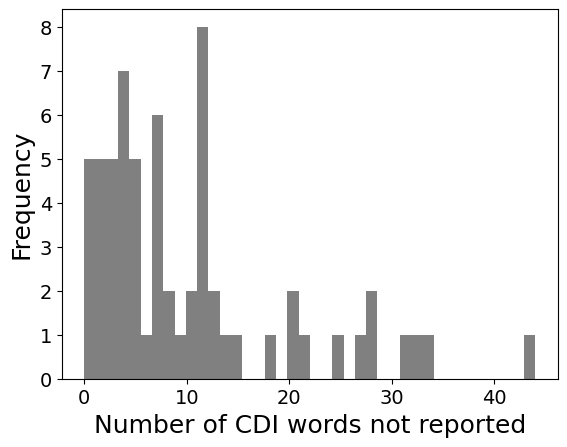

In [86]:
import matplotlib.pyplot as plt

plot_missing_words = plt.hist(words_produced_study['in_audios_no_parents_in_CDI_SPONT'], bins=40,facecolor='grey')

plt.xlabel('Number of CDI words not reported',fontsize=18)
plt.ylabel('Frequency',fontsize=18)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#doc_topics_scores

plt.savefig('Figure_3_missing_CDI_words.png', bbox_inches='tight')


#plt.hist(words_produced_study['in_audios_no_parents_in_CDI_SPONT'], bins=np.arange(words_produced_study['in_audios_no_parents_in_CDI_SPONT'].min(), words_produced_study['in_audios_no_parents_in_CDI_SPONT'].max()+1))


In [87]:
### how is missing so many words? children with vocab sizes too large?

a = words_produced_study['prod_parents'][words_produced_study['in_audios_no_parents_in_CDI_SPONT']>20]
print(a)
print(a.mean(), a.std(), a.min(), a.max())

48     39
26     62
8     244
11    206
2     320
3     318
28    108
10    309
21    253
Name: prod_parents, dtype: object
206.55555555555554 110.69565383418528 39 320


### 5. Stats

In [88]:
import statistics


a =statistics.mean(words_produced_study['prod_parents'])
b =statistics.median(words_produced_study['prod_parents'])
c = min(words_produced_study['prod_parents'])
d = max(words_produced_study['prod_parents'])
e =statistics.stdev(words_produced_study['prod_parents'])

print( f'Reported vocabulary size / Number of words reported by parents / : \n Mean: {a} \n Median: {b}  \n Range {c}-{d} \n sd {e}')

print('.................') 

a =statistics.mean(words_produced_study['prod_audios'])
b =statistics.median(words_produced_study['prod_audios'])
c = min(words_produced_study['prod_audios'])
d = max(words_produced_study['prod_audios'])
e =statistics.stdev(words_produced_study['prod_audios'])

a_2 =statistics.mean(words_produced_study['prod_audios_SPONT'])
b_2 =statistics.median(words_produced_study['prod_audios_SPONT'])
c_2 = min(words_produced_study['prod_audios_SPONT'])
d_2 = max(words_produced_study['prod_audios_SPONT'])
e_2 =statistics.stdev(words_produced_study['prod_audios_SPONT'])

print( f'Number of words produced by the child in the audio recordings: \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')

print('.................') 

a =statistics.mean(words_produced_study['prod_NEW_with_audios_ALL'])
b =statistics.median(words_produced_study['prod_NEW_with_audios_ALL'])
c = min(words_produced_study['prod_NEW_with_audios_ALL'])
d = max(words_produced_study['prod_NEW_with_audios_ALL'])
e =statistics.stdev(words_produced_study['prod_NEW_with_audios_ALL'])

a_2 =statistics.mean(words_produced_study['prod_NEW_with_audios_SPONT_ALL'])
b_2 =statistics.median(words_produced_study['prod_NEW_with_audios_SPONT_ALL'])
c_2 = min(words_produced_study['prod_NEW_with_audios_SPONT_ALL'])
d_2 = max(words_produced_study['prod_NEW_with_audios_SPONT_ALL'])
e_2 =statistics.stdev(words_produced_study['prod_NEW_with_audios_SPONT_ALL'])

print( f'Vocabulary size of the child when considering the words identified in the recordings: \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')

print('.................')

a =statistics.mean(words_produced_study['prod_NEW_with_audios_CDI'])
b =statistics.median(words_produced_study['prod_NEW_with_audios_CDI'])
c = min(words_produced_study['prod_NEW_with_audios_CDI'])
d = max(words_produced_study['prod_NEW_with_audios_CDI'])
e =statistics.stdev(words_produced_study['prod_NEW_with_audios_CDI'])

a_2 =statistics.mean(words_produced_study['prod_NEW_with_audios_SPONT_CDI'])
b_2 =statistics.median(words_produced_study['prod_NEW_with_audios_SPONT_CDI'])
c_2 = min(words_produced_study['prod_NEW_with_audios_SPONT_CDI'])
d_2 = max(words_produced_study['prod_NEW_with_audios_SPONT_CDI'])
e_2 =statistics.stdev(words_produced_study['prod_NEW_with_audios_SPONT_CDI'])

print( f'CDI Vocabulary size of the child when considering the words identified in the recordings: \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')

print('.................')

a =statistics.mean(words_produced_study['dif_prod_NEW_with_audios_CDI'])
b =statistics.median(words_produced_study['dif_prod_NEW_with_audios_CDI'])
c = min(words_produced_study['dif_prod_NEW_with_audios_CDI'])
d = max(words_produced_study['dif_prod_NEW_with_audios_CDI'])
e =statistics.stdev(words_produced_study['dif_prod_NEW_with_audios_CDI'])

a_2 =statistics.mean(words_produced_study['dif_prod_NEW_with_audios_SPONT_CDI'])
b_2 =statistics.median(words_produced_study['dif_prod_NEW_with_audios_SPONT_CDI'])
c_2 = min(words_produced_study['dif_prod_NEW_with_audios_SPONT_CDI'])
d_2 = max(words_produced_study['dif_prod_NEW_with_audios_SPONT_CDI'])
e_2 =statistics.stdev(words_produced_study['dif_prod_NEW_with_audios_SPONT_CDI'])

print( f'Difference between reported vocabulary size of the child and re-calculated CDI vocabulary size: \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')

print('.................')

a =statistics.mean(words_produced_study['dif_prod_NEW_with_audios_ALL'])
b =statistics.median(words_produced_study['dif_prod_NEW_with_audios_ALL'])
c = min(words_produced_study['dif_prod_NEW_with_audios_ALL'])
d = max(words_produced_study['dif_prod_NEW_with_audios_ALL'])
e =statistics.stdev(words_produced_study['dif_prod_NEW_with_audios_ALL'])

a_2 =statistics.mean(words_produced_study['dif_prod_NEW_with_audios_SPONT_ALL'])
b_2 =statistics.median(words_produced_study['dif_prod_NEW_with_audios_SPONT_ALL'])
c_2 = min(words_produced_study['dif_prod_NEW_with_audios_SPONT_ALL'])
d_2 = max(words_produced_study['dif_prod_NEW_with_audios_SPONT_ALL'])
e_2 =statistics.stdev(words_produced_study['dif_prod_NEW_with_audios_SPONT_ALL'])

print( f'Difference between reported vocabulary size of the child and re-calculated ALL WORDS vocabulary size: \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')

print('.................')

a =statistics.mean(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_ALL'])
b =statistics.median(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_ALL'])
c = min(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_ALL'])
d = max(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_ALL'])
e =statistics.stdev(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_ALL'])

a_2 =statistics.mean(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_SPONT_ALL'])
b_2 =statistics.median(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_SPONT_ALL'])
c_2 = min(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_SPONT_ALL'])
d_2 = max(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_SPONT_ALL'])
e_2 =statistics.stdev(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_SPONT_ALL'])


print( f'Percentage of the increase of vocabulary size with re-calculation: \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')

print('.................')

a =statistics.mean(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI'])
b =statistics.median(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI'])
c = min(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI'])
d = max(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI'])
e =statistics.stdev(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI'])

a_2 =statistics.mean(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI_SPONT'])
b_2 =statistics.median(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI_SPONT'])
c_2 = min(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI_SPONT'])
d_2 = max(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI_SPONT'])
e_2 =statistics.stdev(words_produced_study['perc_increase_vocab_size_in_audios_no_parents_in_CDI_SPONT'])


print( f'Percentage of the increase of CDI vocabulary size with re-calculation: \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')

print('.................')

a =statistics.mean(words_produced_study['n_words_overlap'])
b =statistics.median(words_produced_study['n_words_overlap'])
c = min(words_produced_study['n_words_overlap'])
d = max(words_produced_study['n_words_overlap'])
e =statistics.stdev(words_produced_study['n_words_overlap'])

a_2 =statistics.mean(words_produced_study['n_words_overlap_SPONT'])
b_2 =statistics.median(words_produced_study['n_words_overlap_SPONT'])
c_2 = min(words_produced_study['n_words_overlap_SPONT'])
d_2 = max(words_produced_study['n_words_overlap_SPONT'])
e_2 =statistics.stdev(words_produced_study['n_words_overlap_SPONT'])

print( f'Number of words reported that appeared in the audios: \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')

print('.................') 
a =statistics.mean(words_produced_study['perc_words_overlap'])
b =statistics.median(words_produced_study['perc_words_overlap'])
c = min(words_produced_study['perc_words_overlap'])
d = max(words_produced_study['perc_words_overlap'])
e =statistics.stdev(words_produced_study['perc_words_overlap'])

a_2 =statistics.mean(words_produced_study['perc_words_overlap_SPONT'])
b_2 =statistics.median(words_produced_study['perc_words_overlap_SPONT'])
c_2 = min(words_produced_study['perc_words_overlap_SPONT'])
d_2 = max(words_produced_study['perc_words_overlap_SPONT'])
e_2 =statistics.stdev(words_produced_study['perc_words_overlap_SPONT'])

print( f'Percentage of words reported that appeared in the audios: \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')

print('.................') 

a =statistics.mean(words_produced_study['in_audios_no_parents'])
b =statistics.median(words_produced_study['in_audios_no_parents'])
c = min(words_produced_study['in_audios_no_parents'])
d = max(words_produced_study['in_audios_no_parents'])
e =statistics.stdev(words_produced_study['in_audios_no_parents'])

a_2 =statistics.mean(words_produced_study['in_audios_no_parents_SPONT'])
b_2 =statistics.median(words_produced_study['in_audios_no_parents_SPONT'])
c_2 = min(words_produced_study['in_audios_no_parents_SPONT'])
d_2 = max(words_produced_study['in_audios_no_parents_SPONT'])
e_2 =statistics.stdev(words_produced_study['in_audios_no_parents_SPONT'])

print( f'Words that the child produced in the recordings and parent did not report : \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')

print('.................') 

a =statistics.mean(words_produced_study['in_audios_no_parents_in_CDI'])
b =statistics.median(words_produced_study['in_audios_no_parents_in_CDI'])
c = min(words_produced_study['in_audios_no_parents_in_CDI'])
d = max(words_produced_study['in_audios_no_parents_in_CDI'])
e =statistics.stdev(words_produced_study['in_audios_no_parents_in_CDI'])

a_2 =statistics.mean(words_produced_study['in_audios_no_parents_in_CDI_SPONT'])
b_2 =statistics.median(words_produced_study['in_audios_no_parents_in_CDI_SPONT'])
c_2 = min(words_produced_study['in_audios_no_parents_in_CDI_SPONT'])
d_2 = max(words_produced_study['in_audios_no_parents_in_CDI_SPONT'])
e_2 =statistics.stdev(words_produced_study['in_audios_no_parents_in_CDI_SPONT'])

print( f'CDI words not reported that the child produced in the recordings: \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')
print('.................') 


a =statistics.mean(words_produced_study['perc_words_overlap'])
b =statistics.median(words_produced_study['perc_words_overlap'])
c = min(words_produced_study['perc_words_overlap'])
d = max(words_produced_study['perc_words_overlap'])
e =statistics.stdev(words_produced_study['perc_words_overlap'])

a_2 =statistics.mean(words_produced_study['perc_words_overlap_SPONT'])
b_2 =statistics.median(words_produced_study['perc_words_overlap_SPONT'])
c_2 = min(words_produced_study['perc_words_overlap_SPONT'])
d_2 = max(words_produced_study['perc_words_overlap_SPONT'])
e_2 =statistics.stdev(words_produced_study['perc_words_overlap_SPONT'])

print( f'Percentage of words reported that appeared in the audios: \n ALL: \n  Mean: {a} \n  Median: {b}  \n  Range {c}-{d} \n  sd {e} \n SPONTANEOUS: \n  Mean: {a_2} \n  Median: {b_2}  \n  Range {c_2}-{d_2} \n  sd {e_2}')




Reported vocabulary size / Number of words reported by parents / : 
 Mean: 201.42857142857142 
 Median: 181  
 Range 18-386 
 sd 113.61447464089365
.................
Number of words produced by the child in the audio recordings: 
 ALL: 
  Mean: 117.39682539682539 
  Median: 101  
  Range 1-327 
  sd 76.07478062948233 
 SPONTANEOUS: 
  Mean: 53.04761904761905 
  Median: 45  
  Range 1-169 
  sd 38.52248131702158
.................
Vocabulary size of the child when considering the words identified in the recordings: 
 ALL: 
  Mean: 281.3809523809524 
  Median: 264  
  Range 35-528 
  sd 140.16136191287487 
 SPONTANEOUS: 
  Mean: 232.71428571428572 
  Median: 205  
  Range 25-442 
  sd 123.83618583297446
.................
CDI Vocabulary size of the child when considering the words identified in the recordings: 
 ALL: 
  Mean: 225 
  Median: 195  
  Range 21-417 
  sd 115.87019990405838 
 SPONTANEOUS: 
  Mean: 211.74603174603175 
  Median: 184  
  Range 20-397 
  sd 115.00097731056928
.....

In [89]:
# calculate the Pearson's correlation between two variables
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
# seed random number generator

# calculate Pearson's correlation
corr, _ = pearsonr(words_produced_study['prod_parents'], words_produced_study['n_words_overlap'])
print('Pearsons correlation: %.3f' % corr)
print('p. value: %.3f' % _)
corr, _ = pearsonr(words_produced_study['prod_parents'], words_produced_study['n_words_overlap_SPONT'])
print('Pearsons correlation: %.3f' % corr)
print('p. value: %.3f' % _)

corr, _ = pearsonr(words_produced_study['prod_parents'], words_produced_study['prod_audios'])
print('Pearsons correlation: %.3f' % corr)
print('p. value: %.3f' % _)
corr, _ = pearsonr(words_produced_study['prod_parents'], words_produced_study['prod_audios_SPONT'])
print('Pearsons correlation: %.3f' % corr)
print('p. value: %.3f' % _)

corr, _ = pearsonr(words_produced_study['prod_parents'], words_produced_study['in_audios_no_parents'])
print('Pearsons correlation: %.3f' % corr)
print('p. value: %.3f' % _)
corr, _ = pearsonr(words_produced_study['prod_parents'], words_produced_study['in_audios_no_parents_SPONT'])
print('Pearsons correlation: %.3f' % corr)
print('p. value: %.3f' % _)

corr, _ = pearsonr(words_produced_study['prod_parents'], words_produced_study['in_audios_no_parents_in_CDI'])
print('Pearsons correlation: %.3f' % corr)
print('p. value: %.3f' % _)
corr, _ = pearsonr(words_produced_study['prod_parents'], words_produced_study['in_audios_no_parents_in_CDI_SPONT'])
print('Pearsons correlation: %.3f' % corr)
print('p. value: %.3f' % _)

corr, _ = pearsonr(words_produced_study['in_audios_no_parents_in_CDI'], words_produced_study['n_children'])
print('Pearsons correlation: %.3f' % corr)
print('p. value: %.3f' % _)

Pearsons correlation: 0.726
p. value: 0.000
Pearsons correlation: 0.685
p. value: 0.000
Pearsons correlation: 0.504
p. value: 0.000
Pearsons correlation: 0.531
p. value: 0.000
Pearsons correlation: 0.335
p. value: 0.007
Pearsons correlation: 0.359
p. value: 0.004
Pearsons correlation: 0.017
p. value: 0.893
Pearsons correlation: 0.103
p. value: 0.420
Pearsons correlation: 0.292
p. value: 0.020


### Tracking vocabularies

In [90]:
Transcriptions_info =  pyreadr.read_r('Transcriptions_info.rds') 
print(Transcriptions_info.keys()) 
Transcriptions_info_df = Transcriptions_info[None] 
Transcriptions_info_df


odict_keys([None])


,file_name,part_code,day_of_recording,recording_number,topic,file_name_csv,duration_original,vocab_size,age,order
0,P_0318_2_NAPPY_,P_0318,64,2,NAPPY,P_0318_2_NAPPY_.csv,935,40,21.436086,1
1,P_0174_1_BED__,P_0174,145,1,BED,P_0174_1_BED__.csv,1694,66,21.271699,2
2,P_0174_9_NAPPY__BED,P_0174,172,9,NAPPY,P_0174_9_NAPPY__BED.csv,1202,257,25.249868,3
3,P_0174_10_BATH__,P_0174,174,10,BATH,P_0174_10_BATH__.csv,1502,257,25.249868,4
4,P_0174_11_MEAL__,P_0174,396,11,MEAL,P_0174_11_MEAL__.csv,1556,257,25.249868,5
...,...,...,...,...,...,...,...,...,...,...
492,P_0449_6_BATH__,P_0449,87,6,BATH,P_0449_6_BATH__.csv,864,48,19.003156,493
493,P_0277_8_BED__,P_0277,125,8,BED,P_0277_8_BED__.csv,1121,219,18.838769,494
494,P_0298_5_MEAL__,P_0298,109,5,MEAL,P_0298_5_MEAL__.csv,1215,272,27.123882,495
495,P_0437_5_NAPPY__,P_0437,34,5,NAPPY,P_0437_5_NAPPY__.csv,1457,23,16.274329,496


#### Create a dictionary of dictionaries with vocabularies in audios and the days they produced them

In [91]:

import re
import string    

vocabularies_dict_FROM_AUDIOS_SPONTANEOUS_DAYS = {}

for i,part_code in enumerate(set(Transcriptions_info_df['part_code'])):
    
    print(i)
    words_dict ={}
    family_i_info = Transcriptions_info_df[Transcriptions_info_df['file_name'].str[:6]==part_code]

    family_i = transcripts_all[transcripts_all['Audio_file_name'].str[:6]==part_code]
    family_i = family_i[family_i['Utterance'].notna()].copy()
    family_i.shape
    family_i=family_i.reset_index(drop=True).reset_index()
    family_i['Utterance'] = lemmatization(family_i['Utterance'])
    family_i_prev = family_i.copy()
    family_i_prev['index'] = family_i['index'] - 1
    family_x = pd.merge(family_i, family_i_prev, on=['index'], how='inner', suffixes=['_prev','_current'])
    
    for idx_i,f in enumerate(set(family_x['Audio_file_name_current'])):
        family_x_file = family_x[family_x['Audio_file_name_current']==f]
        family_x_file=family_x_file.reset_index(drop=True).reset_index()
        family_i_info_file = family_i_info[family_i_info['file_name']==f]

        for idx,x in enumerate(family_x_file['Utterance_current']):
        
            childs_words = []
            adults_words = []
            childs_spontaneous = []
    
            if family_x_file['Speaker_current'][idx]== 'Child_1':
                lemmatized_utterances_child =family_x_file['Utterance_current'][idx]
                lemmatized_utterances_child = re.sub(r"[\(\[].*?[\)\]]", "", lemmatized_utterances_child)
                lemmatized_utterances_child = lemmatized_utterances_child.translate(str.maketrans('', '', string.punctuation))
                lemmatized_utterances_child = str(lemmatized_utterances_child)
                lemmatized_utterances_child = lemmatized_utterances_child.split()
                
                lemmatized_utterances_adult =family_x_file['Utterance_prev'][idx]
                lemmatized_utterances_adult = re.sub(r"[\(\[].*?[\)\]]", "", lemmatized_utterances_adult)
                lemmatized_utterances_adult = lemmatized_utterances_adult.translate(str.maketrans('', '', string.punctuation))
                lemmatized_utterances_adult = str(lemmatized_utterances_adult)
                lemmatized_utterances_adult = lemmatized_utterances_adult.split()
                
                for child_i in lemmatized_utterances_child:
                    childs_words.append(child_i.lower())
                    
                for adult_i in lemmatized_utterances_adult:
                    adults_words.append(adult_i.lower())
                
                for word_i in childs_words:
                    if word_i in adults_words:
                        childs_spontaneous.append(word_i)
                    
            childs_spontaneous = list(set(childs_spontaneous))
            for w in childs_spontaneous:
                if w not in words_dict:
                    words_dict[w]=family_i_info_file.iloc[0,2]
                if w in words_dict:
                    if words_dict[w] > family_i_info_file.iloc[0,2]:
                        words_dict[w]=family_i_info_file.iloc[0,2]
        
    vocabularies_dict_FROM_AUDIOS_SPONTANEOUS_DAYS[part_code]=words_dict

            
    # for x in family_i_info['day_of_recording']:
    #    words_dict[x]=[]


#vocabularies_dict_FROM_AUDIOS_SPONTANEOUS_DAYS

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


In [92]:
#sorted(vocabularies_dict_FROM_AUDIOS['P_0130'])
#sorted(vocabularies_dict_FROM_AUDIOS_SPONTANEOUS['P_0130'])

#### Create a dictionary of dictionaries with vocabularies reported by parents and the days they were marked

In [93]:
vocabularies_dict_DAYS = {}

for i in range(0,len(set(Vocabularies['part_ID']))):
#for i in range(0,10):

    #print(i)
    id_child = list(set(Vocabularies['part_ID']))[i]
    
    vocab_child = Vocabularies[Vocabularies['part_ID']==id_child]
    index_x =[vocab_child.columns.get_loc("baa baa"), vocab_child.columns.get_loc("rocking chair")]
    vocab_child_only_words = vocab_child.iloc[:,index_x[0]:index_x[1]+1]
  
    words_produced_child = []
    words_dict ={}

    for x in range(0,len(vocab_child_only_words)): # loops throgh rows
        for y in range(0,vocab_child_only_words.shape[1]): # loops throgh columns
            myvar = (vocab_child_only_words.iloc[x,y] == '2')
            myvar = str(myvar)
            myvar = re.findall("True|False", myvar)
            #print(vocab_child_only_words)

            if myvar == ['True'] :
                words_produced_child.append(list(vocab_child_only_words.columns)[y])
                words_dict[list(vocab_child_only_words.columns)[y]]= vocab_child['day_of_data_entry'].iloc[x]
       # print(words_produced_child)
    vocabularies_dict_DAYS[Vocabularies_last_entry.iloc[i,Vocabularies_last_entry.columns.get_loc("part_ID")]] = words_dict



In [94]:
for i,(key,value) in enumerate(vocabularies_dict_DAYS.items()): 
    words_to_add_i = []
    number_to_add_i = []
    words_to_delete_i = []
    words_to_delete_2_i = []

    for i,(key_2,value_2) in enumerate(value.items()):

        if words_CDI['words_in_CDI'].eq(key_2).any():
            word_repl = words_CDI['words_fixed'][list(words_CDI['words_in_CDI']).index(key_2)]
            #value[word_repl] = value[key_2]
            words_to_add_i.append(word_repl)
            number_to_add_i.append(value[key_2])
            words_to_delete_i.append(key_2)

        else : # delete the words id it that's match with or is not in the list 'words_CDI'
            words_to_delete_2_i.append(key_2)
    for idx, q in enumerate(words_to_delete_i):
        del vocabularies_dict_DAYS[key][q]  
    for idx, p in enumerate(words_to_add_i):
        if p in vocabularies_dict_DAYS[key]:
            if number_to_add_i[idx] < vocabularies_dict_DAYS[key][p]: # if it exists, keeps the smallest number
                vocabularies_dict_DAYS[key][p] = number_to_add_i[idx]                
        else:
            vocabularies_dict_DAYS[key][p] = number_to_add_i[idx]

        

        
    for idx, m in enumerate(words_to_delete_2_i):
        del vocabularies_dict_DAYS[key][m] 
  

In [95]:
key,words_to_delete_2_i,len(number_to_add_i),len(words_to_add_i),len(set(words_to_add_i))


('P_0271',
 ['pet’s name', 'don’t', 'this little piggy', 'so big!'],
 351,
 351,
 347)

In [96]:
len(vocabularies_dict_DAYS['P_0369']),len(vocabularies_dict['P_0369']),len(set(vocabularies_dict['P_0369']))

#counter = collections.Counter(vocabularies_dict['P_0369'])
#counter

(352, 362, 352)

In [97]:
df_cl =  pd.DataFrame.from_dict(vocabularies_dict_DAYS, orient='index')
df_cl = pd.melt(df_cl, ignore_index=False)
df_cl.rename(columns={'value':'checklist_day', 'variable':'word'}, inplace=True)
df_cl['part_code'] = df_cl.index

df_tra = pd.DataFrame.from_dict(vocabularies_dict_FROM_AUDIOS_SPONTANEOUS_DAYS, orient='index')
df_tra = pd.melt(df_tra, ignore_index=False)
df_tra.rename(columns={'value':'transcript_day', 'variable':'word'}, inplace=True)
df_tra['part_code'] = df_tra.index

df_final = pd.merge(df_cl, df_tra, left_on=['part_code','word'], right_on=['part_code','word'], how='outer')
df_final = df_final[['part_code','word','checklist_day','transcript_day']]

In [98]:
both_populated = df_final[~((df_final['checklist_day'].isnull()) | (df_final['transcript_day'].isnull()) )].copy()
both_populated.shape

(1371, 4)

In [99]:
both_populated.sort_values(by=['part_code'], ascending=True, inplace=True)

In [100]:
both_populated['checklist_day_lower'] = 0
both_populated['transcript_day_lower'] = 0
both_populated.loc[both_populated['checklist_day'] < both_populated['transcript_day'] , 'checklist_day_lower'] = 1
both_populated.loc[both_populated['checklist_day'] > both_populated['transcript_day'] , 'transcript_day_lower'] = 1

In [101]:
both_populated

,part_code,word,checklist_day,transcript_day,checklist_day_lower,transcript_day_lower
14832,P_0130,blue,127.0,81.0,0,1
17730,P_0130,yellow,68.0,69.0,1,0
31338,P_0130,i,35.0,6.0,0,1
1980,P_0130,baby,0.0,29.0,1,0
11619,P_0130,nose,0.0,47.0,1,0
...,...,...,...,...,...,...
14964,P_0524,where,136.0,166.0,1,0
11625,P_0524,nose,0.0,55.0,1,0
1734,P_0524,more,0.0,27.0,1,0
13893,P_0524,ball,43.0,166.0,1,0


In [102]:
sum(both_populated['checklist_day_lower']),sum(both_populated['transcript_day_lower']),(sum(both_populated['checklist_day_lower'])+sum(both_populated['transcript_day_lower']))

(939, 389, 1328)

In [103]:
(sum(both_populated['checklist_day_lower'])+sum(both_populated['transcript_day_lower'])) - 1371

-43

In [104]:
checklist_vs_day_by_family =pd.pivot_table(both_populated, values=['checklist_day_lower','transcript_day_lower'], index=None, columns='part_code', aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False, sort=True)
checklist_vs_day_by_family=checklist_vs_day_by_family.transpose()
checklist_vs_day_by_family['difference'] = checklist_vs_day_by_family['checklist_day_lower'] -checklist_vs_day_by_family['transcript_day_lower']
print(sum(checklist_vs_day_by_family['difference']<0),sum(checklist_vs_day_by_family['difference']>0),sum(checklist_vs_day_by_family['difference']==0))
print(checklist_vs_day_by_family['checklist_day_lower'].mean())
print(checklist_vs_day_by_family['transcript_day_lower'].mean())

#checklist_vs_day_by_family.shape # some children did not produced the marked words in the recordings
checklist_vs_day_by_family.head()



5 48 6
0.6770415314430189
0.28874683557562386


,checklist_day_lower,transcript_day_lower,difference
part_code,,,
P_0130,0.578947,0.368421,0.210526
P_0137,0.666667,0.190476,0.476190
P_0141,0.500000,0.500000,0.000000
P_0146,1.000000,0.000000,1.000000
P_0149,0.857143,0.142857,0.714286


In [105]:
checklist_vs_day_by_family_SUM =pd.pivot_table(both_populated, values=['checklist_day_lower','transcript_day_lower'], index=None, columns='part_code', aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False, sort=True)
checklist_vs_day_by_family_SUM=checklist_vs_day_by_family_SUM.transpose()
checklist_vs_day_by_family_SUM['difference'] = checklist_vs_day_by_family_SUM['checklist_day_lower'] -checklist_vs_day_by_family_SUM['transcript_day_lower']
print(sum(checklist_vs_day_by_family_SUM['difference']<0),sum(checklist_vs_day_by_family_SUM['difference']>0),sum(checklist_vs_day_by_family_SUM['difference']==0))
print(checklist_vs_day_by_family_SUM['checklist_day_lower'].median())
print(checklist_vs_day_by_family_SUM['transcript_day_lower'].median())

#checklist_vs_day_by_family.shape # some children did not produced the marked words in the recordings
checklist_vs_day_by_family_SUM.head()

5 48 6
14.0
5.0


,checklist_day_lower,transcript_day_lower,difference
part_code,,,
P_0130,11,7,4
P_0137,14,4,10
P_0141,4,4,0
P_0146,1,0,1
P_0149,18,3,15


In [106]:
from scipy import stats

gradient, intercept, r_value, p_value, std_err = stats.linregress(checklist_vs_day_by_family['checklist_day_lower'],checklist_vs_day_by_family['transcript_day_lower'])
print("Gradient and intercept", gradient, intercept)
print("R-squared", r_value**2)
print("p-value", p_value)


Gradient and intercept -0.9396378837037134 0.9249207073602633
R-squared 0.846755862484786
p-value 6.923673996593508e-25


(<seaborn.axisgrid.FacetGrid at 0x27bb3ba69e0>,
 <seaborn.axisgrid.FacetGrid at 0x27ba588a230>)

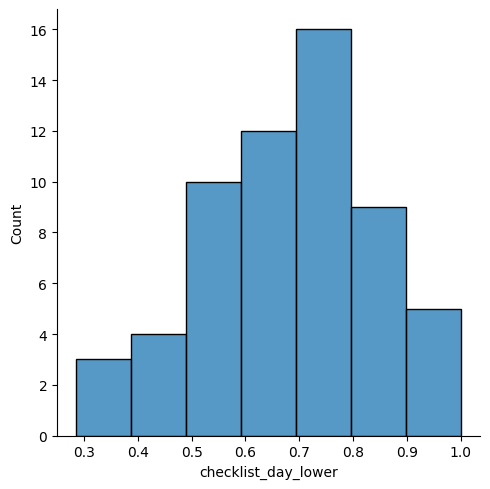

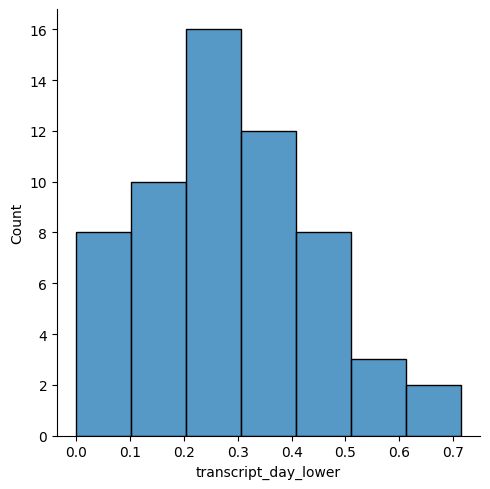

In [107]:
import seaborn as sns
sns.displot(checklist_vs_day_by_family, x='checklist_day_lower'),sns.displot(checklist_vs_day_by_family, x='transcript_day_lower')

In [108]:
# Mann-Whitney U test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
# seed the random number generator
seed(1)

# compare samples
stat, p = mannwhitneyu(checklist_vs_day_by_family['checklist_day_lower'], checklist_vs_day_by_family['transcript_day_lower'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=3257.500, p=0.000
Different distribution (reject H0)
